# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:
#
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
train_params = [(le_ra, re_st) for le_ra in learning_rates for re_st in regularization_strengths]
for lrate, regular in train_params:
    svm = LinearSVM()
    loss_hist = svm.train(X_train_feats, y_train, learning_rate=lrate, reg=regular,
                      num_iters=700, verbose=False)
    y_train_pred = svm.predict(X_train_feats)
    accuracy_train = np.mean(y_train == y_train_pred)
    y_val_pred = svm.predict(X_val_feats)
    accuracy_val = np.mean(y_val == y_val_pred)
    results[(lrate, regular)]=(accuracy_train, accuracy_val)
    if (best_val < accuracy_val):
        best_val = accuracy_val
        best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

[[-0.16591662 -0.24127758 -0.45310857 ... -0.42660707 -0.49443299
   1.        ]
 [-0.56557135 -0.70502556 -0.67148276 ...  0.58209683  0.01352884
   1.        ]
 [-0.16856306  1.70952915  1.09731534 ... -0.37969061 -0.49443299
   1.        ]
 ...
 [ 4.87619165  3.91234699  3.76935079 ... -0.47352353 -0.52906675
   1.        ]
 [-0.63283004 -0.62203656 -0.56667075 ...  2.5760464   2.41480296
   1.        ]
 [-0.65325965 -0.61474992 -0.69848389 ... -0.47352353 -0.55215593
   1.        ]]
[[-0.42954216 -0.29807034  0.15687515 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.22012641 -0.67512162 -0.57888664 ... -0.47352353 -0.55215593
   1.        ]
 [-0.62629674 -0.7156692  -0.69848389 ...  0.48826391  1.42196847
   1.        ]
 ...
 [-0.67476146 -0.58483726 -0.5477789  ... -0.26239945 -0.47134382
   1.        ]
 [-0.66420472 -0.39192652 -0.57267685 ... -0.47352353 -0.55215593
   1.        ]
 [-0.64092182 -0.7156692   1.12316811 ...  0.72284621  0.20978682
   1.        ]]
[[-0.67476146 -0

   1.        ]]
[[-0.31268302 -0.20050804  0.70083925 ... -0.47352353 -0.55215593
   1.        ]
 [ 1.48402759  0.38623542  1.36195023 ... -0.47352353 -0.41362088
   1.        ]
 [-0.58380585 -0.13377561 -0.44701356 ... -0.37969061 -0.41362088
   1.        ]
 ...
 [ 0.46557596  1.12985421 -0.11090231 ... -0.47352353 -0.55215593
   1.        ]
 [-0.22376681  0.56018866  1.3115209  ... -0.33277414 -0.32126418
   1.        ]
 [ 0.62285869  0.73105813  2.45512754 ... -0.33277414 -0.45979923
   1.        ]]
[[ 1.56872064 -0.67391724 -0.17333818 ... -0.37969061 -0.39053171
   1.        ]
 [-0.61600052 -0.25371026 -0.69848389 ...  0.44134745  0.82164994
   1.        ]
 [ 2.45952242 -0.48124445  2.78032632 ... -0.37969061 -0.44825464
   1.        ]
 ...
 [ 0.87196046  2.47537176  0.87859775 ... -0.47352353 -0.55215593
   1.        ]
 [-0.06520627 -0.7156692  -0.67734905 ... -0.35623237 -0.42516547
   1.        ]
 [-0.50587645 -0.6375337  -0.60769328 ... -0.40314884 -0.55215593
   1.        ]]


[[ 2.63155126  8.68247554  3.60171216 ...  0.27713984  1.47969141
   1.        ]
 [-0.41057747 -0.62848476 -0.53362708 ... -0.28585768 -0.34435336
   1.        ]
 [-0.30824918 -0.7156692  -0.69848389 ... -0.4500653  -0.55215593
   1.        ]
 ...
 [ 0.45042652  1.90572559  0.52754764 ... -0.28585768  0.75238242
   1.        ]
 [-0.43874956 -0.58997673 -0.63963141 ... -0.30931591 -0.36744253
   1.        ]
 [-0.0516811  -0.49095237  1.89453941 ... -0.42660707 -0.35589795
   1.        ]]
[[ 1.61476525  1.07634721  2.58672397 ... -0.1451083  -0.24045207
   1.        ]
 [ 2.72632121  4.12692022  0.28479415 ... -0.28585768  1.82602902
   1.        ]
 [-0.66269877 -0.67943793 -0.64448164 ...  1.28584374  0.4060448
   1.        ]
 ...
 [ 2.26794954  0.16810909 -0.69848389 ... -0.33277414 -0.35589795
   1.        ]
 [ 0.53326831 -0.29078345 -0.24397203 ... -0.47352353 -0.54061134
   1.        ]
 [-0.38898433 -0.70170661 -0.63696876 ...  0.74630444  1.74521691
   1.        ]]
[[-0.27154858 -0.

   1.        ]]
[[-0.67476146 -0.7156692  -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.07344227  0.22881336  2.50951735 ... -0.37969061 -0.33280877
   1.        ]
 [-0.59138484 -0.7156692  -0.67148276 ... -0.07473361 -0.1250062
   1.        ]
 ...
 [-0.60814079 -0.35121862  0.1652286  ... -0.00435892  1.51432517
   1.        ]
 [ 0.03929234  2.07483158  0.36928507 ... -0.37969061 -0.41362088
   1.        ]
 [-0.06893845 -0.35196424 -0.65821175 ...  0.44134745  1.14489838
   1.        ]]
[[-6.52818708e-01 -7.15669199e-01 -6.44481644e-01 ... -4.73523526e-01
  -5.52155926e-01  1.00000000e+00]
 [-6.56405034e-01  7.69883214e-01  7.13588032e-01 ... -4.03148835e-01
  -3.21264184e-01  1.00000000e+00]
 [-3.95214712e-01 -6.07206487e-01 -6.94562140e-01 ...  6.60157684e-02
  -3.44353358e-01  1.00000000e+00]
 ...
 [-4.67581025e-01 -7.08655154e-02 -4.73449865e-02 ...  2.03650710e+00
   2.09155452e+00  1.00000000e+00]
 [-4.95168749e-01  3.32608722e-01  1.82635073e+00 ...  1.19201082e+0

[[-0.4938293  -0.58941747 -0.57845057 ...  6.18861385  5.02387965
   1.        ]
 [-0.03484499 -0.08258073  0.94872082 ... -0.37969061 -0.51752216
   1.        ]
 [-0.67476146 -0.7156692  -0.61945323 ...  1.12163613 -0.13655079
   1.        ]
 ...
 [-0.64471484 -0.7156692  -0.6167324  ... -0.30931591 -0.39053171
   1.        ]
 [-0.64680718 -0.36791244 -0.69848389 ... -0.09819184 -0.42516547
   1.        ]
 [-0.36707209  0.51038496  1.31727353 ... -0.16856653  0.26750976
   1.        ]]
[[-0.56302878 -0.69442008 -0.30219293 ... -0.47352353 -0.55215593
   1.        ]
 [-0.34886322 -0.45009208  0.41316252 ...  0.11293223 -0.10191703
   1.        ]
 [ 0.33682644  1.63208748 -0.69848389 ... -0.33277414 -0.49443299
   1.        ]
 ...
 [-0.26957661 -0.64973618 -0.32161774 ...  1.89575772  1.00636333
   1.        ]
 [ 1.12579527 -0.17253956 -0.14528321 ... -0.23894122 -0.29817501
   1.        ]
 [-0.54362084  1.29876807 -0.34588419 ... -0.47352353 -0.55215593
   1.        ]]
[[-0.5927505  -0

[[-0.53338733  1.2403231   0.15584256 ... -0.47352353 -0.52906675
   1.        ]
 [-0.42878104 -0.50255628  0.0628687  ...  0.60555506  0.01352884
   1.        ]
 [-0.3159334  -0.7156692  -0.67148276 ...  0.089474   -0.09037244
   1.        ]
 ...
 [ 1.32412659 -0.28511355  1.50379768 ...  0.48826391  0.12897471
   1.        ]
 [-0.5041796   0.44718739  3.94200586 ...  2.64642109  0.32523269
   1.        ]
 [-0.32108843 -0.7156692  -0.60900999 ...  0.04255754  0.34832187
   1.        ]]
[[-0.67476146 -0.7156692  -0.69848389 ... -0.30931591 -0.02110492
   1.        ]
 [-0.15503237  0.17246336  0.03121003 ... -0.47352353 -0.55215593
   1.        ]
 [-0.05722561  0.85410349  1.89060819 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.6115785  -0.07368882  0.47168527 ... -0.35623237 -0.51752216
   1.        ]
 [-0.62177443 -0.7156692  -0.66782892 ... -0.00435892  2.66878388
   1.        ]
 [-0.67476146 -0.2410432  -0.46893728 ... -0.47352353 -0.39053171
   1.        ]]
[[-1.60140206e-0

  -5.52155926e-01  1.00000000e+00]]
[[-0.67476146 -0.67966591 -0.69848389 ... -0.4500653   0.20978682
   1.        ]
 [ 0.04177414 -0.23069031  0.18547039 ... -0.12165007 -0.34435336
   1.        ]
 [-0.59757018 -0.7156692  -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.66281304 -0.7156692  -0.69848389 ...  0.27713984 -0.07882785
   1.        ]
 [ 1.66564127 -0.19026097  0.47997208 ... -0.19202476  0.32523269
   1.        ]
 [-0.12075625 -0.15788548 -0.02820354 ...  3.77241614  1.24879966
   1.        ]]
[[-0.66777289 -0.7156692  -0.69848389 ...  1.05126144  2.14927746
   1.        ]
 [-0.67476146 -0.69736095 -0.53848495 ...  0.48826391 -0.37898712
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.21548299 -0.47134382
   1.        ]
 ...
 [-0.2241869  -0.37300176 -0.14028152 ... -0.47352353 -0.55215593
   1.        ]
 [-0.46142158 -0.7156692  -0.66185979 ... -0.42660707  0.86782829
   1.        ]
 [-0.57476361 -0.35717539 -0.38982991 ... -0.4500653  -0.55215

   1.        ]]
[[-0.67476146 -0.7156692  -0.69848389 ... -0.28585768 -0.54061134
   1.        ]
 [ 1.0623992   1.04522267 -0.63301129 ...  0.41788922  0.0481626
   1.        ]
 [ 2.96183331  0.45940872  0.00323209 ... -0.40314884 -0.51752216
   1.        ]
 ...
 [-0.63149345 -0.56436547 -0.34651621 ... -0.47352353 -0.55215593
   1.        ]
 [-0.50391375 -0.55927986 -0.24604882 ... -0.42660707 -0.54061134
   1.        ]
 [-0.57501616 -0.31591911 -0.5360117  ... -0.47352353 -0.55215593
   1.        ]]
[[-0.16872467  0.5080172  -0.49044269 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.24079397 -0.7156692  -0.67507151 ... -0.37969061 -0.44825464
   1.        ]
 [-0.67476146 -0.66420322 -0.5722712  ... -0.09819184 -0.17118455
   1.        ]
 ...
 [ 0.819565    0.45377049  1.27981048 ... -0.05127538  0.08279637
   1.        ]
 [ 1.56751336  0.54317046  1.59421303 ... -0.33277414 -0.05573868
   1.        ]
 [-0.35005044 -0.6239235  -0.64743789 ...  1.26238551  1.94147489
   1.        ]]
[

   1.        ]]
[[-0.19203446  0.05548681  0.23063395 ... -0.4500653  -0.55215593
   1.        ]
 [-0.36572001  0.63206468  1.32993447 ...  0.34751453  0.17515306
   1.        ]
 [-0.620968   -0.55857757 -0.1004065  ... -0.35623237 -0.36744253
   1.        ]
 ...
 [-0.16390667 -0.1121106  -0.09821189 ...  0.58209683  0.4060448
   1.        ]
 [-0.60789111 -0.66904055 -0.65378763 ...  0.34751453  0.45222315
   1.        ]
 [-0.62689315 -0.7037873  -0.67148276 ...  0.84013736  4.23884772
   1.        ]]
[[ 0.51039276  1.15026679 -0.27469095 ... -0.47352353 -0.55215593
   1.        ]
 [-0.67476146 -0.7156692  -0.66922593 ... -0.4500653  -0.52906675
   1.        ]
 [-0.15942236  1.33762025  0.45821267 ... -0.1451083   0.81010535
   1.        ]
 ...
 [ 2.82274873 -0.7156692  -0.17817407 ...  0.5586386   1.14489838
   1.        ]
 [ 0.73465012 -0.32244376  2.19860779 ... -0.23894122  1.24879966
   1.        ]
 [-0.61338994 -0.44279491 -0.58614382 ... -0.4500653  -0.55215593
   1.        ]]
[

   1.        ]]
[[-0.60756967 -0.7156692  -0.69848389 ...  0.93397029  0.42913398
   1.        ]
 [ 0.04955242 -0.12787696  1.98854551 ...  1.66117542  4.31965983
   1.        ]
 [-0.19689281 -0.00828107 -0.02809171 ... -0.33277414 -0.44825464
   1.        ]
 ...
 [-0.58932731 -0.43406951 -0.22342811 ... -0.42660707 -0.55215593
   1.        ]
 [ 0.37361806 -0.48235207 -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.96454061  0.15220939 -0.11707277 ... -0.47352353  0.50994609
   1.        ]]
[[ 6.52422986e-03  5.23493684e-01  2.64349545e-01 ... -2.15482994e-01
  -4.71343816e-01  1.00000000e+00]
 [ 2.15174495e-01 -7.15669199e-01  4.88777935e+00 ...  4.17889221e-01
   3.82955630e-01  1.00000000e+00]
 [-5.00382527e-01 -4.09965329e-01 -2.75405852e-01 ...  6.93927721e+00
   4.67754203e+00  1.00000000e+00]
 ...
 [-6.74761462e-01 -6.46918099e-01 -5.86001562e-01 ...  5.58638602e-01
   6.83114895e-01  1.00000000e+00]
 [-6.00016251e-01 -5.91151001e-01 -6.19284004e-01 ... -4.50065296e-

  -2.86630422e-01  1.00000000e+00]]
[[-0.61557659 -0.69337999 -0.55969618 ... -0.02781715 -0.22890749
   1.        ]
 [ 2.48723232  4.17307387  1.41802958 ... -0.21548299 -0.40207629
   1.        ]
 [ 1.10398904  1.57439836 -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.39072718 -0.63478005  1.26771561 ... -0.19202476 -0.50597758
   1.        ]
 [-0.0785016  -0.64624787 -0.50109096 ... -0.00435892 -0.25199666
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.26239945  0.71774866
   1.        ]]
[[-0.20938538 -0.7156692  -0.69848389 ... -0.40314884 -0.49443299
   1.        ]
 [-0.52621422 -0.45461373 -0.38666171 ... -0.47352353 -0.55215593
   1.        ]
 [-0.46257387 -0.44838416 -0.69848389 ... -0.35623237 -0.55215593
   1.        ]
 ...
 [ 0.32781013 -0.53569196 -0.16490383 ... -0.4500653  -0.55215593
   1.        ]
 [-0.39052733 -0.65461654 -0.59976179 ... -0.1451083  -0.2173629
   1.        ]
 [-0.63370759 -0.06151213  0.59834129 ... -0.47352353 -0.552155

[[-0.05493879  0.54458887  0.26674434 ... -0.23894122  0.03661802
   1.        ]
 [-0.21902246 -0.7156692  -0.67640664 ... -0.37969061 -0.51752216
   1.        ]
 [-0.2482483  -0.50110436 -0.44131263 ... -0.26239945  1.15644297
   1.        ]
 ...
 [-0.33950988  1.36591649  0.95160612 ... -0.12165007 -0.37898712
   1.        ]
 [ 3.61289339 -0.18114127  0.43330258 ...  0.46480568  0.34832187
   1.        ]
 [-0.08109246  0.98059504  0.05446055 ... -0.40314884  0.33677728
   1.        ]]
[[-0.37678693  0.79308667  0.18570501 ...  0.13639046 -0.06728327
   1.        ]
 [-0.62943802 -0.46298287 -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.4522431   0.17664903 -0.23757351 ...  0.15984869 -0.36744253
   1.        ]
 ...
 [-0.66882457 -0.7156692   0.70389625 ...  0.5586386   0.03661802
   1.        ]
 [ 0.06008456  0.4640898  -0.17453011 ... -0.19202476 -0.25199666
   1.        ]
 [-0.59852622 -0.7156692  -0.62050813 ... -0.35623237 -0.44825464
   1.        ]]
[[-4.82286562e-0

   1.        ]]
[[ 0.01363027 -0.03151153 -0.08661501 ...  0.58209683  0.18669765
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [-0.43491794  1.02312496 -0.42607776 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.45012378 -0.10320211 -0.52261281 ...  0.88705382  0.24442058
   1.        ]
 [ 0.22354151  1.84858302  0.15836747 ... -0.23894122 -0.44825464
   1.        ]
 [-0.37786904 -0.7156692  -0.55848349 ... -0.1451083  -0.3097196
   1.        ]]
[[ 2.13382083 -0.7156692   0.65289715 ... -0.07473361  0.11743013
   1.        ]
 [-0.26362669 -0.03370816 -0.48529428 ... -0.47352353 -0.55215593
   1.        ]
 [-0.67476146 -0.68279667 -0.6674772  ... -0.47352353 -0.55215593
   1.        ]
 ...
 [ 0.48890869  0.09356663 -0.06931912 ... -0.26239945 -0.50597758
   1.        ]
 [-0.45998731 -0.41682282  0.73296464 ... -0.23894122 -0.13655079
   1.        ]
 [-0.27645726 -0.7156692  -0.60645149 ...  0.37097276  0.11743013
   1.        ]]
[

  -4.36710055e-01  1.00000000e+00]]
[[-0.45268701 -0.38318444 -0.4518328  ... -0.40314884 -0.51752216
   1.        ]
 [-0.42898352  0.23217691 -0.25033893 ...  2.20071471  0.61384737
   1.        ]
 [ 2.30585549  1.25668483 -0.6331569  ...  0.30059807  0.19824224
   1.        ]
 ...
 [-0.04623534 -0.61749046  0.11652629 ... -0.30931591 -0.41362088
   1.        ]
 [ 1.01739921  0.57448416  0.6448874  ... -0.42660707 -0.50597758
   1.        ]
 [ 0.17219726  1.11123518  1.80413602 ...  0.72284621  1.58359269
   1.        ]]
[[ 1.54860522 -0.55980941  0.61038258 ... -0.12165007 -0.40207629
   1.        ]
 [-0.67476146  3.27840436  2.29215768 ... -0.12165007 -0.00956033
   1.        ]
 [-0.50262643 -0.67789276 -0.53295032 ... -0.28585768 -0.52906675
   1.        ]
 ...
 [-0.38963199 -0.7156692  -0.33339503 ...  0.46480568  1.98765324
   1.        ]
 [-0.00607359 -0.45163998 -0.57126868 ... -0.19202476  1.3065226
   1.        ]
 [-0.63213803 -0.54284253 -0.53647716 ... -0.23894122 -0.309719

   1.        ]]
[[-0.63675134 -0.7156692  -0.59063714 ...  0.30059807  1.81448443
   1.        ]
 [-0.65273245 -0.7156692  -0.67162656 ...  0.13639046  0.15206389
   1.        ]
 [ 1.31693851  1.18593736  0.49967274 ... -0.42660707 -0.40207629
   1.        ]
 ...
 [-0.63446797 -0.657046   -0.69848389 ... -0.47352353 -0.49443299
   1.        ]
 [-0.67476146 -0.64487183 -0.53407395 ...  0.60555506  0.34832187
   1.        ]
 [-0.67476146 -0.32565815  1.06262663 ... -0.09819184 -0.25199666
   1.        ]]
[[ 1.7455545  -0.39131059  0.1417883  ...  0.13639046 -0.26354125
   1.        ]
 [ 0.84991731 -0.7156692   1.6122709  ... -0.1451083  -0.24045207
   1.        ]
 [-0.53205485 -0.55996484 -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.41764928 -0.4112878   0.90271739 ... -0.37969061 -0.47134382
   1.        ]
 [-0.48893117 -0.22711509 -0.69848389 ...  0.27713984 -0.20581831
   1.        ]
 [-0.46443773 -0.49639539 -0.48212668 ... -0.37969061 -0.28663042
   1.        ]]


   1.        ]]
[[ 0.9616447   0.68002435 -0.42698509 ... -0.4500653  -0.55215593
   1.        ]
 [ 0.14014659 -0.39306491 -0.69848389 ... -0.40314884 -0.39053171
   1.        ]
 [-0.50888781 -0.47209634 -0.63044722 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.55685667 -0.49040245 -0.59245761 ... -0.1451083  -0.37898712
   1.        ]
 [ 2.05132435 -0.58952283 -0.58072967 ... -0.26239945 -0.33280877
   1.        ]
 [ 0.57364242  2.06844943  3.00619244 ... -0.47352353 -0.52906675
   1.        ]]
[[-0.65379575 -0.7156692  -0.69848389 ... -0.1451083  -0.55215593
   1.        ]
 [-0.67476146 -0.7156692  -0.67329939 ... -0.4500653  -0.52906675
   1.        ]
 [ 0.19627438 -0.63845044 -0.09441521 ... -0.19202476  0.34832187
   1.        ]
 ...
 [ 1.51918941  0.22611748 -0.4097007  ... -0.47352353 -0.54061134
   1.        ]
 [-0.64672025 -0.7156692  -0.69848389 ... -0.40314884 -0.54061134
   1.        ]
 [-0.54699641 -0.6589862  -0.69848389 ... -0.47352353 -0.55215593
   1.        ]]


   1.        ]]
[[-0.38739933 -0.62639621 -0.49117441 ... -0.47352353 -0.55215593
   1.        ]
 [-0.08771456  1.45296999 -0.16869407 ... -0.42660707 -0.42516547
   1.        ]
 [-0.60523435 -0.29979954 -0.65165914 ... -0.40314884 -0.54061134
   1.        ]
 ...
 [-0.43141559 -0.54769815 -0.630528   ... -0.47352353 -0.55215593
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.09819184  0.48685691
   1.        ]
 [ 0.8219302   5.51493383  0.87644403 ...  2.17725648  2.72650681
   1.        ]]
[[-0.36537799 -0.7156692  -0.69848389 ... -0.21548299  0.12897471
   1.        ]
 [-0.63381122 -0.07162249  0.50569921 ...  1.00434498  0.32523269
   1.        ]
 [-0.64169806 -0.58996099 -0.67148276 ...  4.00699844  0.91400664
   1.        ]
 ...
 [-0.61459621 -0.70183854 -0.67767628 ... -0.21548299  0.50994609
   1.        ]
 [-0.63686216 -0.64555814 -0.66182781 ... -0.00435892 -0.06728327
   1.        ]
 [-0.64680718 -0.66234618 -0.69848389 ... -0.47352353 -0.54061134
   1.        ]]


   1.        ]]
[[-0.38557905  1.77325176  1.28178083 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.85292442 -0.24101956 -0.21579406 ... -0.42660707 -0.06728327
   1.        ]
 [-0.16821483 -0.7156692   0.14915987 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.67476146  0.1790433  -0.29004509 ... -0.37969061 -0.49443299
   1.        ]
 [ 0.41219797  0.50612841 -0.10951505 ... -0.12165007 -0.52906675
   1.        ]
 [-0.37142391 -0.1947525   0.09867949 ... -0.33277414 -0.51752216
   1.        ]]
[[-0.3181422   0.91256969 -0.12784358 ... -0.37969061 -0.52906675
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [-0.61300457 -0.51751436 -0.64448164 ...  0.88705382  0.68311489
   1.        ]
 ...
 [ 0.01767713  0.22190268 -0.69848389 ... -0.07473361 -0.36744253
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.40314884 -0.54061134
   1.        ]
 [ 1.96397899 -0.65434561 -0.6252214  ...  0.30059807  1.64131562
   1.        ]]


   1.        ]]
[[ 1.99927873  2.32903035  0.31114644 ... -0.35623237 -0.49443299
   1.        ]
 [ 0.2090076   0.05775601  0.5329525  ...  1.66117542  2.87658645
   1.        ]
 [-0.67476146 -0.55680046 -0.47618495 ...  1.98959064  3.0959336
   1.        ]
 ...
 [-0.59652043 -0.51342806 -0.34154103 ... -0.37969061 -0.45979923
   1.        ]
 [-0.22376211  2.69401807  0.3780904  ... -0.47352353 -0.55215593
   1.        ]
 [ 0.10971278 -0.46237401 -0.69848389 ...  0.06601577  0.27905435
   1.        ]]
[[-0.67476146 -0.17369597 -0.0196013  ... -0.42660707 -0.52906675
   1.        ]
 [ 0.7335536   0.04566555  2.63555155 ...  3.86624906  1.73367232
   1.        ]
 [ 1.27495504  0.9139915  -0.46024163 ...  0.62901329 -0.24045207
   1.        ]
 ...
 [ 0.21883406  0.33267228 -0.63939485 ... -0.47352353 -0.49443299
   1.        ]
 [ 1.10458476 -0.62967995 -0.56652621 ... -0.19202476 -0.52906675
   1.        ]
 [ 0.50482948 -0.06722085 -0.69848389 ... -0.12165007 -0.37898712
   1.        ]]
[

[[-0.52837219 -0.7156692  -0.08760288 ... -0.4500653  -0.49443299
   1.        ]
 [ 0.69626468  0.56441906  2.27205761 ... -0.42660707 -0.44825464
   1.        ]
 [-0.67476146 -0.608321   -0.42065321 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [ 1.42776727  0.92074745  1.51845503 ...  0.37097276 -0.1250062
   1.        ]
 [-0.54314615 -0.7156692  -0.69848389 ... -0.09819184 -0.20581831
   1.        ]
 [-0.56110868 -0.7156692  -0.51163615 ... -0.09819184 -0.44825464
   1.        ]]
[[-0.6676942  -0.70842075 -0.67148276 ... -0.19202476 -0.43671005
   1.        ]
 [-0.67476146 -0.5160493  -0.66938013 ... -0.47352353 -0.55215593
   1.        ]
 [ 3.92949548  1.03564543  2.36356016 ... -0.1451083  -0.03264951
   1.        ]
 ...
 [-0.09624937 -0.01814485 -0.53196271 ... -0.35623237 -0.55215593
   1.        ]
 [-0.41868928 -0.0393631  -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [-0.67476146 -0.7156692  -0.58490725 ... -0.4500653  -0.55215593
   1.        ]]
[[-0.67476146 -0.

   1.        ]]
[[-0.07981957 -0.68822087 -0.69848389 ... -0.23894122  0.68311489
   1.        ]
 [ 1.45019592 -0.7156692  -0.40943112 ... -0.42660707  3.46536039
   1.        ]
 [-0.6045272  -0.7156692  -0.24431397 ... -0.42660707 -0.55215593
   1.        ]
 ...
 [-0.20760073 -0.26319821  0.19916154 ... -0.42660707 -0.55215593
   1.        ]
 [-0.67476146 -0.58255269 -0.39457193 ...  1.00434498  0.1405193
   1.        ]
 [-0.67476146 -0.69657957 -0.63231238 ... -0.4500653  -0.15963996
   1.        ]]
[[ 0.22836148  0.25339082  2.0347876  ...  0.65247152  0.75238242
   1.        ]
 [-0.48710427 -0.37792793 -0.53299286 ... -0.4500653  -0.55215593
   1.        ]
 [-0.67476146 -0.62678512 -0.69848389 ... -0.4500653  -0.39053171
   1.        ]
 ...
 [ 2.65857359 -0.7156692  -0.69848389 ... -0.33277414 -0.25199666
   1.        ]
 [-0.64507949 -0.24346351  0.61976153 ...  3.49091737  3.1882903
   1.        ]
 [-0.08723681 -0.12701387 -0.69848389 ... -0.42660707 -0.54061134
   1.        ]]
[[

   1.        ]]
[[-0.44978842 -0.6687451  -0.69848389 ... -0.05127538 -0.19427373
   1.        ]
 [-0.61918192 -0.5596948   0.78199079 ... -0.28585768 -0.47134382
   1.        ]
 [ 2.05483822  1.6845492  -0.17724103 ... -0.30931591  0.09434095
   1.        ]
 ...
 [-0.54373146 -0.658258    1.30329713 ...  0.11293223  0.05970719
   1.        ]
 [-0.58304971 -0.63246076 -0.44161821 ...  1.91921595  0.75238242
   1.        ]
 [-0.57323423 -0.18214589 -0.28593652 ... -0.47352353 -0.55215593
   1.        ]]
[[-0.38748332 -0.4008321  -0.53418089 ...  0.06601577 -0.09037244
   1.        ]
 [ 0.39221215 -0.57259938 -0.69848389 ...  0.06601577  1.82602902
   1.        ]
 [-0.45015848 -0.4848924  -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.64680718 -0.7156692   1.26098679 ...  0.13639046 -0.18272914
   1.        ]
 [-0.60593968 -0.6594114  -0.56173168 ...  0.39443099  2.49561507
   1.        ]
 [-0.58982952 -0.71038189 -0.69848389 ... -0.00435892 -0.20581831
   1.        ]]


   1.        ]]
[[-0.67476146 -0.54470618 -0.26607791 ... -0.40314884 -0.47134382
   1.        ]
 [-0.22833627 -0.68233008  0.2322893  ... -0.47352353 -0.51752216
   1.        ]
 [-0.64167633 -0.65887398 -0.69848389 ... -0.30931591 -0.37898712
   1.        ]
 ...
 [-0.47391079 -0.29017226  0.0592648  ... -0.28585768 -0.49443299
   1.        ]
 [-0.52868363 -0.35686526 -0.22897192 ...  0.23022338  0.05970719
   1.        ]
 [-0.32837635  0.42644766 -0.6289493  ... -0.40314884 -0.3097196
   1.        ]]
[[-0.21093963  0.79857682  1.52027953 ...  2.27108941  0.03661802
   1.        ]
 [-0.31683722 -0.20394106 -0.08880393 ... -0.47352353 -0.55215593
   1.        ]
 [-0.57283245 -0.56836512 -0.27331729 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.14164488 -0.05258082  0.62612007 ... -0.47352353 -0.51752216
   1.        ]
 [-0.32929778  6.19581764  0.94362822 ... -0.42660707 -0.25199666
   1.        ]
 [-0.66574417 -0.69839861 -0.67525768 ... -0.26239945 -0.41362088
   1.        ]]
[

   1.        ]]
[[ 1.89008562  0.7708973  -0.43935271 ... -0.21548299 -0.29817501
   1.        ]
 [-0.31121949 -0.34172938  0.35649682 ... -0.40314884 -0.45979923
   1.        ]
 [ 1.20690707  0.31078547  0.74228373 ...  0.20676515 -0.24045207
   1.        ]
 ...
 [ 0.14024473 -0.31972393 -0.44409748 ... -0.47352353 -0.49443299
   1.        ]
 [ 0.09103493  0.35986264 -0.27031064 ... -0.1451083  -0.24045207
   1.        ]
 [ 2.83853168  1.82370006  4.23325222 ... -0.35623237 -0.54061134
   1.        ]]
[[-0.41790694  0.56973133 -0.54118336 ...  0.51172214  2.24163415
   1.        ]
 [-0.1304742   1.61408098 -0.69848389 ...  0.51172214 -0.02110492
   1.        ]
 [-0.4787811  -0.43164808 -0.31185462 ...  0.13639046 -0.1250062
   1.        ]
 ...
 [-0.23160226 -0.6836597  -0.67730965 ... -0.28585768 -0.35589795
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ...  0.06601577  0.02507343
   1.        ]
 [ 2.79692321  0.25004427 -0.58642787 ... -0.07473361  0.89091746
   1.        ]]
[

   1.        ]]
[[ 2.79667948  1.14778101  1.59503859 ...  0.13639046 -0.13655079
   1.        ]
 [-0.0670036  -0.33160201  2.30456155 ... -0.4500653  -0.49443299
   1.        ]
 [-0.6358358  -0.7156692  -0.62909363 ... -0.40314884 -0.52906675
   1.        ]
 ...
 [-0.61953907 -0.62646761 -0.64462563 ... -0.16856653 -0.26354125
   1.        ]
 [-0.38818748 -0.15791026 -0.41039577 ... -0.42660707 -0.14809538
   1.        ]
 [ 0.61758665  0.10873642  1.64100309 ... -0.30931591 -0.50597758
   1.        ]]
[[-5.96810419e-01 -4.11635087e-01 -4.84727758e-01 ... -4.73523526e-01
  -4.59799229e-01  1.00000000e+00]
 [ 5.28101083e+00 -6.84938656e-01 -2.04273855e-01 ...  2.30223380e-01
   9.43409522e-02  1.00000000e+00]
 [-6.74761462e-01 -7.15669199e-01 -6.98483886e-01 ... -4.03148835e-01
  -5.52155926e-01  1.00000000e+00]
 ...
 [ 1.51155822e+00 -5.83687750e-01 -5.75835600e-01 ... -4.35892216e-03
   4.81626038e-02  1.00000000e+00]
 [ 2.02839361e+00  3.45391774e+00  1.00214681e+00 ... -4.26607065e-

   1.        ]]
[[-0.60571592 -0.60659995 -0.59960594 ... -0.40314884 -0.51752216
   1.        ]
 [-0.67476146 -0.7156692  -0.0734011  ... -0.35623237 -0.4828884
   1.        ]
 [-0.21778948 -0.46675256 -0.54825604 ...  2.66987932  0.46376774
   1.        ]
 ...
 [-0.64981294 -0.7156692  -0.69848389 ...  6.75161137  1.90684113
   1.        ]
 [-0.46794978 -0.5238564  -0.22520277 ...  2.48221348  1.32961177
   1.        ]
 [-0.67476146 -0.7156692  -0.63184878 ... -0.30931591 -0.42516547
   1.        ]]
[[-0.27651205  0.46752131  1.19280661 ... -0.30931591 -0.4828884
   1.        ]
 [-0.12961956 -0.48064291  0.31372576 ... -0.35623237 -0.37898712
   1.        ]
 [ 1.75780151  3.37116738  0.79545044 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.60131543 -0.7156692  -0.69848389 ...  0.76976267  0.31368811
   1.        ]
 [ 4.45238089  5.40785287  1.24322115 ... -0.09819184  0.33677728
   1.        ]
 [-0.42789199 -0.68659374 -0.69848389 ... -0.42660707 -0.4828884
   1.        ]]
[[ 

   1.        ]]
[[-0.12740917 -0.67936735 -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.3040083  -0.36329775  0.96590143 ...  0.34751453  0.03661802
   1.        ]
 [-0.63465932 -0.67198943 -0.51346851 ...  0.13639046  0.42913398
   1.        ]
 ...
 [-0.57846781 -0.46806225 -0.44739601 ...  0.18330692 -0.11346162
   1.        ]
 [ 1.00988171  0.63475195  0.39395333 ... -0.42660707 -0.51752216
   1.        ]
 [-0.65800474 -0.65566674 -0.50033964 ...  0.7932209  -0.07882785
   1.        ]]
[[-0.67476146 -0.7156692  -0.69848389 ... -0.28585768  0.55612444
   1.        ]
 [ 3.32281562  5.73615405 -0.56760838 ... -0.23894122  0.02507343
   1.        ]
 [-0.54014249 -0.57456173 -0.56522888 ... -0.4500653  -0.52906675
   1.        ]
 ...
 [-0.67476146 -0.50536824  0.52675188 ...  0.37097276  0.44067857
   1.        ]
 [-0.67476146 -0.7156692  -0.67148276 ... -0.47352353 -0.55215593
   1.        ]
 [-0.13272172 -0.04844007  0.10136488 ...  0.60555506 -0.07882785
   1.        ]]


   1.        ]]
[[-0.18501768 -0.66128639 -0.69848389 ... -0.35623237 -0.41362088
   1.        ]
 [ 0.10857929 -0.45432786 -0.69848389 ...  1.75500834  2.19545581
   1.        ]
 [-0.0377763  -0.18021835  3.65520682 ...  0.25368161  0.03661802
   1.        ]
 ...
 [-0.22670008 -0.49874929 -0.69848389 ... -0.19202476  0.47531233
   1.        ]
 [-0.67476146 -0.48645137  0.15756022 ... -0.47352353 -0.55215593
   1.        ]
 [-0.45512298 -0.27489284  0.32081346 ... -0.37969061 -0.44825464
   1.        ]]
[[ 0.88549039 -0.7156692  -0.69848389 ...  2.10688179  3.70779672
   1.        ]
 [-0.67476146 -0.26225588 -0.40611912 ... -0.47352353 -0.50597758
   1.        ]
 [-0.4222768  -0.7156692  -0.22023532 ... -0.47352353 -0.47134382
   1.        ]
 ...
 [ 2.2477918   0.84960488  0.15401427 ...  0.37097276  2.63415012
   1.        ]
 [ 2.70913635  1.58215614  1.53487566 ... -0.16856653 -0.47134382
   1.        ]
 [ 0.2776527   0.92620426  0.76419844 ... -0.16856653  5.17395928
   1.        ]]


[[-0.48853886 -0.70027195 -0.42792104 ...  1.37967666  0.37141104
   1.        ]
 [-0.51465666  0.13828094  0.03637153 ... -0.37969061  1.26034425
   1.        ]
 [-0.66777289 -0.59566429 -0.67148276 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.27475009 -0.49074338 -0.69848389 ... -0.26239945 -0.27508584
   1.        ]
 [ 0.29099348  0.82893554  0.6985559  ...  1.54388427  0.82164994
   1.        ]
 [-0.56735191 -0.34960011 -0.4261764  ... -0.47352353 -0.55215593
   1.        ]]
[[-0.67476146 -0.17345294 -0.33122281 ... -0.4500653  -0.55215593
   1.        ]
 [ 0.1223992   1.17346986 -0.69848389 ... -0.07473361 -0.11346162
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.1451083  -0.11346162
   1.        ]
 ...
 [-0.64840392 -0.7156692  -0.69078853 ... -0.16856653 -0.39053171
   1.        ]
 [-0.28139477 -0.45296614 -0.61934547 ...  2.36492233  0.50994609
   1.        ]
 [-0.07473028 -0.09969917 -0.69848389 ... -0.05127538 -0.22890749
   1.        ]]
[[ 0.56547122  0

   1.        ]]
[[-0.67476146  0.92275688  0.88942506 ... -0.47352353 -0.55215593
   1.        ]
 [-0.63411032 -0.31488208 -0.43123479 ... -0.47352353 -0.55215593
   1.        ]
 [-0.18781543  0.21184942  0.34949733 ... -0.12165007 -0.20581831
   1.        ]
 ...
 [-0.64558388 -0.70040992 -0.6886894  ... -0.23894122 -0.47134382
   1.        ]
 [ 3.01250752 -0.54758158  0.23548019 ...  1.26238551  1.37579012
   1.        ]
 [-0.58274707 -0.7156692  -0.69848389 ... -0.47352353 -0.55215593
   1.        ]]
[[-0.63614047 -0.6922846  -0.14435271 ...  0.46480568  4.36583818
   1.        ]
 [-0.38612443  0.23755223  0.06552808 ... -0.23894122 -0.24045207
   1.        ]
 [ 1.22362318  2.84569684  1.22571496 ... -0.4500653  -0.55215593
   1.        ]
 ...
 [-0.65076719 -0.70052183 -0.69848389 ... -0.35623237 -0.55215593
   1.        ]
 [-0.62473984 -0.5722481  -0.51456463 ... -0.47352353 -0.54061134
   1.        ]
 [ 1.12819788 -0.34615013 -0.12357037 ... -0.23894122  0.0481626
   1.        ]]
[

   1.        ]]
[[-0.47677131 -0.4464989  -0.17390609 ...  0.41788922 -0.34435336
   1.        ]
 [-0.46048756  0.20857561  1.5431237  ... -0.42660707 -0.42516547
   1.        ]
 [-0.66078432 -0.69201204 -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [ 0.48422431  3.61127352  2.12154703 ... -0.42660707 -0.54061134
   1.        ]
 [ 2.90552869  0.49845155 -0.69848389 ... -0.26239945 -0.54061134
   1.        ]
 [-0.64594685 -0.7156692  -0.64448164 ... -0.47352353 -0.55215593
   1.        ]]
[[-0.54224206 -0.37900248 -0.3224332  ... -0.4500653  -0.52906675
   1.        ]
 [-0.29234063  0.63053085  1.19023214 ... -0.47352353 -0.55215593
   1.        ]
 [-0.66277316 -0.7156692  -0.69848389 ... -0.30931591  1.36424553
   1.        ]
 ...
 [-0.30768775  0.56516224  0.72009255 ... -0.42660707 -0.49443299
   1.        ]
 [-0.56704221 -0.5725371   0.2685765  ... -0.47352353 -0.55215593
   1.        ]
 [-0.64445892 -0.67714671 -0.67119851 ... -0.47352353 -0.55215593
   1.        ]]


   7.63927005e-01  1.00000000e+00]]
[[ 0.26615299  0.78812816  0.21373194 ... -0.40314884 -0.55215593
   1.        ]
 [ 0.01917646 -0.23157689 -0.38319431 ... -0.37969061 -0.45979923
   1.        ]
 [-0.25729368  0.30423243 -0.69848389 ... -0.26239945 -0.52906675
   1.        ]
 ...
 [-0.6071663  -0.18609875 -0.44626734 ... -0.47352353 -0.55215593
   1.        ]
 [-0.20805612  0.94011088 -0.29428534 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.16004504  0.69235118 -0.5422705  ... -0.33277414 -0.45979923
   1.        ]]
[[ 0.07077461  0.61562936  1.30504682 ... -0.35623237 -0.47134382
   1.        ]
 [-0.65351793 -0.7156692  -0.69848389 ... -0.35623237 -0.50597758
   1.        ]
 [ 0.12915901  1.69511743  0.87204842 ...  1.84884126 -0.1250062
   1.        ]
 ...
 [-0.31504949 -0.62665973 -0.64294196 ... -0.33277414 -0.45979923
   1.        ]
 [-0.60829229 -0.61832035 -0.56485705 ...  0.11293223  0.68311489
   1.        ]
 [-0.50110084 -0.55014257 -0.66199663 ... -0.47352353 -0.552155

[[ 0.36103016 -0.38893783 -0.15727266 ...  0.25368161 -0.09037244
   1.        ]
 [ 0.32080226  4.5786561   2.12472085 ...  1.14509436  2.4725259
   1.        ]
 [-0.67476146 -0.35009887 -0.11776518 ... -0.19202476 -0.25199666
   1.        ]
 ...
 [ 1.03063495  0.6364733   1.65798657 ...  3.42054268  2.98048773
   1.        ]
 [ 0.66392761  1.99946617  0.96913934 ... -0.47352353 -0.45979923
   1.        ]
 [ 0.51477994  2.1109643   0.37072579 ...  1.14509436  0.52149068
   1.        ]]
[[ 5.7769508  -0.63210971 -0.30348588 ... -0.40314884 -0.51752216
   1.        ]
 [-0.19274053 -0.52137975  0.02652226 ...  0.76976267  1.80293984
   1.        ]
 [-0.67476146  0.08211109 -0.47054679 ... -0.47352353 -0.4828884
   1.        ]
 ...
 [-0.55686159 -0.7156692  -0.56455439 ... -0.33277414 -0.44825464
   1.        ]
 [-0.53942435 -0.54945819 -0.57613477 ... -0.1451083  -0.44825464
   1.        ]
 [-0.67476146 -0.45157743  0.55839724 ... -0.4500653  -0.47134382
   1.        ]]
[[-0.33775933 -0.6

   1.        ]]
[[ 0.01767713  0.22190268 -0.69848389 ... -0.07473361 -0.36744253
   1.        ]
 [-0.6155544  -0.7156692  -0.63457951 ... -0.40314884 -0.51752216
   1.        ]
 [-0.52586927  0.19560989 -0.33016485 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.59780831 -0.7156692  -0.64448164 ... -0.33277414 -0.52906675
   1.        ]
 [ 0.19606009  1.48039789  0.16926405 ... -0.47352353 -0.32126418
   1.        ]
 [ 1.48454798  0.7251469   0.47846772 ... -0.40314884 -0.44825464
   1.        ]]
[[-0.47841009  0.01791943 -0.63620288 ...  0.23022338  0.22133141
   1.        ]
 [-0.6474746  -0.7156692  -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [ 1.29054961  3.20210488  0.61028605 ...  0.04255754 -0.49443299
   1.        ]
 ...
 [ 0.77431384  0.03914838  0.32107124 ...  0.25368161 -0.02110492
   1.        ]
 [-0.64320142 -0.66851077 -0.52230886 ... -0.42660707 -0.51752216
   1.        ]
 [-0.57316029 -0.45312158 -0.41253061 ... -0.4500653  -0.52906675
   1.        ]]


   1.        ]]
[[ 2.35686458e-01 -3.15858588e-01  4.84496269e-01 ... -9.81918429e-02
   1.98425536e-03  1.00000000e+00]
 [-3.40729029e-01  3.36255499e-01 -5.50417969e-02 ...  4.88263912e-01
  -1.82729138e-01  1.00000000e+00]
 [-6.07225424e-01 -7.15669199e-01 -6.67409270e-01 ... -4.03148835e-01
  -5.17522165e-01  1.00000000e+00]
 ...
 [-6.60784321e-01 -7.15669199e-01 -6.72739788e-01 ...  2.03650710e+00
   4.98401501e-01  1.00000000e+00]
 [-6.74761462e-01 -7.15669199e-01 -6.98483886e-01 ... -4.03148835e-01
   7.40837830e-01  1.00000000e+00]
 [-5.40499872e-01  5.16439217e-01 -2.35421591e-01 ... -4.73523526e-01
  -5.40611339e-01  1.00000000e+00]]
[[-0.58704617 -0.67200945 -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.09819184  0.01352884
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.33277414 -0.28663042
   1.        ]
 ...
 [ 0.07391034 -0.35604064  0.61278294 ... -0.28585768 -0.34435336
   1.        ]
 [-0.27415597 -0.20

   1.        ]]
[[-0.35673837  0.28572095  0.88923782 ...  0.01909931 -0.19427373
   1.        ]
 [-0.56811952 -0.7156692   0.97840324 ... -0.33277414 -0.33280877
   1.        ]
 [ 1.16747053  3.3608354   6.96163569 ... -0.33277414 -0.40207629
   1.        ]
 ...
 [-0.62555716 -0.7156692   0.13228461 ... -0.47352353 -0.54061134
   1.        ]
 [ 0.62154836 -0.51293726 -0.28040465 ... -0.47352353 -0.55215593
   1.        ]
 [-0.67476146 -0.70146847 -0.69848389 ... -0.4500653  -0.52906675
   1.        ]]
[[-0.0719788  -0.19154504 -0.4434585  ... -0.30931591  1.95301948
   1.        ]
 [ 1.18750972  2.22750056  0.47822591 ... -0.35623237 -0.50597758
   1.        ]
 [-0.50933703 -0.7156692  -0.55459546 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.40576183  0.26459607 -0.61327197 ... -0.19202476 -0.32126418
   1.        ]
 [-0.21157117 -0.12243987 -0.56874095 ... -0.47352353 -0.55215593
   1.        ]
 [-0.32904997 -0.7156692  -0.32517013 ... -0.28585768 -0.4828884
   1.        ]]
[

   1.        ]]
[[-0.04821692  0.21489565  0.77199178 ...  0.58209683  0.55612444
   1.        ]
 [-0.57585705 -0.7156692   0.38928169 ... -0.37969061 -0.40207629
   1.        ]
 [ 2.62775513 -0.7156692  -0.69848389 ... -0.16856653 -0.51752216
   1.        ]
 ...
 [ 2.1577585  -0.48330581 -0.69848389 ... -0.37969061 -0.47134382
   1.        ]
 [ 0.3239348  -0.49352806  0.34267611 ... -0.47352353 -0.55215593
   1.        ]
 [-0.67476146 -0.40412672 -0.14257865 ...  0.089474   -0.22890749
   1.        ]]
[[-0.54042629 -0.51149385 -0.5094823  ... -0.47352353 -0.52906675
   1.        ]
 [ 0.06184604 -0.06739171  0.87168933 ... -0.37969061  0.99481875
   1.        ]
 [-0.551266   -0.62840588 -0.63864969 ...  0.089474    4.23884772
   1.        ]
 ...
 [-0.54184338 -0.52600546 -0.53778013 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.03571359  0.82589571  2.54244825 ... -0.35623237 -0.28663042
   1.        ]
 [-0.34431473  0.80552487 -0.18818705 ... -0.4500653  -0.54061134
   1.        ]]


[[ 2.875024    0.53947566  0.998522   ... -0.16856653  0.55612444
   1.        ]
 [ 1.04809507  2.49220305  5.36296909 ...  0.39443099  1.5720481
   1.        ]
 [ 3.69967749  0.2543798   0.04721048 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.13032902 -0.60936021  0.44643339 ... -0.28585768 -0.4828884
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.42660707 -0.54061134
   1.        ]
 [ 0.99017417 -0.28362267  1.99917062 ... -0.42660707 -0.45979923
   1.        ]]
[[-0.55620492 -0.6645229  -0.69848389 ... -0.02781715  1.14489838
   1.        ]
 [-0.46291849 -0.47017549 -0.69848389 ...  0.25368161 -0.05573868
   1.        ]
 [-0.65059657 -0.69001001 -0.69848389 ... -0.4500653  -0.54061134
   1.        ]
 ...
 [-0.55948274  0.35146428 -0.52195901 ... -0.19202476 -0.29817501
   1.        ]
 [ 2.17304909  0.62202571 -0.69848389 ... -0.12165007  1.0409971
   1.        ]
 [ 1.07534685 -0.2280733  -0.69848389 ... -0.26239945 -0.47134382
   1.        ]]
[[-0.58134565 -0.71

   1.        ]]
[[-0.66070969 -0.7156692  -0.69456214 ... -0.28585768 -0.39053171
   1.        ]
 [-0.58813574 -0.4104149  -0.16505037 ...  1.26238551  0.63693655
   1.        ]
 [-0.35392409 -0.49891797 -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.47129623  0.03643697  0.0136652  ... -0.47352353 -0.55215593
   1.        ]
 [ 0.6869098  -0.7156692  -0.69848389 ... -0.4500653  -0.55215593
   1.        ]
 [ 0.59501779 -0.39321752  0.22125526 ... -0.19202476 -0.40207629
   1.        ]]
[[ 0.23341499  0.07102212  2.77041679 ... -0.47352353 -0.55215593
   1.        ]
 [-0.62027775 -0.7156692  -0.69848389 ...  1.87229949  0.96018499
   1.        ]
 [-0.66062267 -0.14339253  0.45479865 ...  0.089474    0.79856077
   1.        ]
 ...
 [ 0.23536193 -0.64124531 -0.67148276 ... -0.42660707 -0.51752216
   1.        ]
 [-0.67183033 -0.7156692  -0.66337476 ... -0.4500653  -0.55215593
   1.        ]
 [ 0.9656181  -0.62372105 -0.46028915 ... -0.37969061  0.05970719
   1.        ]]


   1.        ]]
[[ 0.2818779  -0.45307921 -0.58869609 ... -0.28585768 -0.49443299
   1.        ]
 [-0.61827589 -0.7156692  -0.67148276 ... -0.47352353 -0.37898712
   1.        ]
 [-0.19736506  0.21169006 -0.01370683 ... -0.12165007 -0.33280877
   1.        ]
 ...
 [-0.67476146 -0.70713206 -0.69078853 ... -0.47352353 -0.55215593
   1.        ]
 [-0.39275046 -0.30598376  0.07390093 ... -0.47352353 -0.44825464
   1.        ]
 [-0.6044151  -0.7156692  -0.69848389 ...  2.15379825  0.92555122
   1.        ]]
[[-0.56023657 -0.50488336 -0.58991353 ... -0.37969061  0.45222315
   1.        ]
 [ 2.06441168  1.09519913  1.0376013  ... -0.47352353 -0.55215593
   1.        ]
 [-0.35336009 -0.6858696  -0.57926064 ... -0.4500653  -0.55215593
   1.        ]
 ...
 [-0.58803662 -0.7156692  -0.69848389 ... -0.00435892  0.57921361
   1.        ]
 [-0.66064839 -0.7156692  -0.69848389 ... -0.23894122 -0.41362088
   1.        ]
 [ 1.6507895   0.55058255 -0.49216035 ... -0.16856653 -0.05573868
   1.        ]]


   1.        ]]
[[-0.56448588 -0.60001523 -0.51850492 ... -0.33277414 -0.51752216
   1.        ]
 [-0.62268643 -0.12807749 -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.04804649  0.6748794  -0.25357057 ...  0.39443099  0.86782829
   1.        ]
 ...
 [-0.11053398  0.44821478  0.71622274 ...  0.34751453 -0.18272914
   1.        ]
 [-0.57087328 -0.7156692   1.56777257 ... -0.40314884 -0.55215593
   1.        ]
 [ 0.68343437  0.84603739  0.29658025 ...  0.34751453  0.30214352
   1.        ]]
[[ 4.28777492e+00 -5.02207320e-01  1.36859529e+00 ...  1.16855259e+00
   4.64290827e+00  1.00000000e+00]
 [-6.32830039e-01 -7.15669199e-01 -6.71482765e-01 ... -3.56232375e-01
  -4.94432990e-01  1.00000000e+00]
 [-6.39592361e-01 -6.72569293e-01 -5.81988436e-01 ... -4.73523526e-01
  -5.52155926e-01  1.00000000e+00]
 ...
 [ 3.56302147e-01 -3.62487608e-01 -5.60804644e-01 ... -4.73523526e-01
  -5.52155926e-01  1.00000000e+00]
 [ 6.87505939e-01  4.52632309e-01  2.80585528e+00 ... -2.78171523e-

   1.        ]]
[[ 0.07949968  0.58490976 -0.47695483 ... -0.37969061 -0.34435336
   1.        ]
 [ 1.10799796  0.57904907  0.29894157 ... -0.05127538 -0.28663042
   1.        ]
 [ 2.03593641 -0.12995495  0.089107   ... -0.09819184 -0.40207629
   1.        ]
 ...
 [-0.06960328 -0.58922017 -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [-0.63682982 -0.58792264 -0.65560596 ... -0.19202476  0.93709581
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.37969061 -0.39053171
   1.        ]]
[[ 0.42844613  0.57111965 -0.69848389 ... -0.42660707 -0.49443299
   1.        ]
 [-0.39683625 -0.36197362 -0.40009732 ... -0.47352353 -0.55215593
   1.        ]
 [-0.51124869 -0.7156692   0.4286922  ... -0.47352353 -0.43671005
   1.        ]
 ...
 [ 4.16420032 -0.51122943 -0.63340082 ... -0.33277414 -0.49443299
   1.        ]
 [ 2.23104104  0.7200507   0.28146775 ... -0.47352353 -0.55215593
   1.        ]
 [-0.39789746  0.09533614 -0.02248887 ... -0.47352353 -0.55215593
   1.        ]]


   1.        ]]
[[-0.41238426 -0.21425474  0.90851352 ...  1.75500834  3.3614591
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.05127538  1.17953214
   1.        ]
 [-0.14401652  2.13467137  3.02859724 ... -0.16856653 -0.35589795
   1.        ]
 ...
 [-0.65890487 -0.7156692  -0.67148276 ... -0.37969061 -0.39053171
   1.        ]
 [ 0.56716329  0.54652587 -0.61748052 ... -0.12165007 -0.06728327
   1.        ]
 [-0.67476146 -0.59568177 -0.69848389 ... -0.42660707 -0.51752216
   1.        ]]
[[ 0.45493342  3.33612816  0.85635024 ...  9.09743439  1.62977104
   1.        ]
 [-0.67476146 -0.22913666  0.41005457 ... -0.37969061 -0.50597758
   1.        ]
 [-0.51949139  0.07988346 -0.25327332 ...  0.46480568  0.15206389
   1.        ]
 ...
 [ 0.97085558  1.21308648 -0.69848389 ... -0.30931591 -0.47134382
   1.        ]
 [-0.60897787 -0.570055    0.0662219  ... -0.47352353 -0.45979923
   1.        ]
 [-0.58598936  0.06927355  0.12419701 ... -0.4500653  -0.55215593
   1.        ]]
[

   1.        ]]
[[-0.04708924 -0.2071166  -0.55513727 ... -0.05127538 -0.1250062
   1.        ]
 [-0.29191864 -0.6312697  -0.07895827 ... -0.47352353 -0.03264951
   1.        ]
 [ 1.73504615 -0.68523567  0.21511872 ...  0.27713984  0.60230279
   1.        ]
 ...
 [ 0.94566784  0.85055629  0.18673776 ...  1.35621843  2.72650681
   1.        ]
 [-0.00288677 -0.1771475  -0.0421138  ... -0.4500653  -0.45979923
   1.        ]
 [-0.63160209 -0.69162852 -0.61805713 ... -0.42660707 -0.45979923
   1.        ]]
[[ 0.93227619  0.70192195  1.58072569 ...  0.3240563   1.22571049
   1.        ]
 [-0.63876139 -0.7156692  -0.67495291 ... -0.40314884 -0.19427373
   1.        ]
 [-0.62072525 -0.7156692  -0.69848389 ... -0.30931591 -0.51752216
   1.        ]
 ...
 [-0.28489245 -0.325205    0.14143059 ... -0.47352353 -0.49443299
   1.        ]
 [ 0.10569543  0.16698911  0.47605912 ... -0.26239945  2.3801692
   1.        ]
 [-0.09324191  0.05326721  0.35194978 ... -0.37969061 -0.45979923
   1.        ]]
[[

   1.        ]]
[[-0.64592268 -0.6760604  -0.54357339 ... -0.12165007 -0.40207629
   1.        ]
 [-0.64012606 -0.08656861  0.11366313 ...  0.37097276  0.75238242
   1.        ]
 [-0.61779135 -0.57131368 -0.23371416 ... -0.42660707 -0.47134382
   1.        ]
 ...
 [-0.36313503  0.30340966 -0.03633174 ...  0.58209683 -0.04419409
   1.        ]
 [ 0.20337836 -0.38812758 -0.53412893 ... -0.47352353 -0.54061134
   1.        ]
 [-0.3675047  -0.44130148 -0.48817648 ... -0.05127538 -0.04419409
   1.        ]]
[[-0.46552855 -0.30547503 -0.69848389 ...  3.91316552  2.40325837
   1.        ]
 [-0.66980161 -0.6622622  -0.69848389 ... -0.47352353 -0.52906675
   1.        ]
 [-0.40208308 -0.7156692  -0.5010373  ... -0.47352353 -0.55215593
   1.        ]
 ...
 [ 0.26661833  1.06722101  0.70288903 ...  0.15984869 -0.06728327
   1.        ]
 [-0.55733765 -0.64080223 -0.3449071  ... -0.19202476 -0.35589795
   1.        ]
 [ 1.24303529 -0.42683865 -0.69848389 ...  0.20676515 -0.02110492
   1.        ]]


   1.        ]]
[[-0.05481805 -0.2656047  -0.39203751 ... -0.30931591 -0.4828884
   1.        ]
 [-0.30647578  1.29213525 -0.20264267 ... -0.42660707 -0.06728327
   1.        ]
 [-0.51928722 -0.54702643 -0.51157143 ...  1.12163613 -0.19427373
   1.        ]
 ...
 [-0.67476146 -0.7156692  -0.69848389 ...  1.40313489  1.81448443
   1.        ]
 [ 0.04388998 -0.31771496 -0.57207413 ... -0.40314884 -0.45979923
   1.        ]
 [-0.09093992  0.31504611  1.69440158 ... -0.47352353 -0.55215593
   1.        ]]
[[ 2.88785486  1.88137956  5.70180744 ... -0.19202476 -0.4828884
   1.        ]
 [ 1.2044794   1.03996754  0.1833868  ... -0.40314884 -0.41362088
   1.        ]
 [-0.67476146 -0.69642608 -0.69848389 ... -0.47352353 -0.52906675
   1.        ]
 ...
 [-0.52413706 -0.48631599 -0.66926984 ... -0.4500653  -0.55215593
   1.        ]
 [ 3.9669155   3.65792135 -0.01412116 ... -0.16856653  0.20978682
   1.        ]
 [-0.65752702 -0.7156692  -0.69093406 ...  0.20676515 -0.07882785
   1.        ]]
[[

   1.        ]]
[[-0.29966537 -0.7156692  -0.24982332 ... -0.4500653  -0.55215593
   1.        ]
 [-0.40062961 -0.20078501 -0.44687164 ... -0.16856653 -0.43671005
   1.        ]
 [-0.67476146 -0.7156692  -0.64773666 ...  0.089474    1.84911819
   1.        ]
 ...
 [-0.6587556  -0.7156692  -0.69848389 ... -0.33277414 -0.43671005
   1.        ]
 [ 1.17626162 -0.49984074  0.20722108 ... -0.47352353 -0.54061134
   1.        ]
 [-0.03501781  1.34065026  0.4729522  ... -0.30931591 -0.19427373
   1.        ]]
[[-0.42506341 -0.55820938 -0.43525376 ... -0.30931591 -0.45979923
   1.        ]
 [-0.60848539 -0.7070339  -0.67917624 ... -0.47352353 -0.55215593
   1.        ]
 [-0.67476146 -0.22881959  0.03603878 ... -0.42660707 -0.51752216
   1.        ]
 ...
 [-0.22070144 -0.60272847 -0.5469878  ... -0.40314884 -0.51752216
   1.        ]
 [-0.63908588 -0.64936457  0.81591812 ... -0.33277414 -0.40207629
   1.        ]
 [-0.57882912 -0.37104794 -0.40597051 ... -0.47352353 -0.41362088
   1.        ]]


   1.        ]]
[[-0.67476146 -0.7156692  -0.62354789 ... -0.47352353 -0.55215593
   1.        ]
 [-0.63694759 -0.65129773 -0.63815178 ... -0.47352353 -0.55215593
   1.        ]
 [-0.43333119  0.50464575 -0.26239839 ... -0.40314884 -0.1250062
   1.        ]
 ...
 [ 0.15263418  0.13939357 -0.61586595 ... -0.40314884 -0.52906675
   1.        ]
 [-0.65763471 -0.61350266 -0.62457992 ... -0.4500653  -0.4828884
   1.        ]
 [-0.62064957 -0.69755357 -0.61748052 ... -0.37969061 -0.4828884
   1.        ]]
[[-0.19287473  0.0380519   0.14545976 ... -0.19202476 -0.25199666
   1.        ]
 [ 0.57859327  1.06041428 -0.13603881 ... -0.00435892 -0.20581831
   1.        ]
 [ 0.64379872  0.82313868 -0.4203256  ...  0.44134745  1.47969141
   1.        ]
 ...
 [-0.4832941  -0.39745539 -0.5340211  ... -0.47352353  0.55612444
   1.        ]
 [-0.59180498 -0.55518025 -0.32212382 ... -0.23894122 -0.33280877
   1.        ]
 [-0.2771565   0.12833178 -0.58457933 ... -0.33277414  0.48685691
   1.        ]]
[[-

   1.        ]]
[[-5.83349083e-01 -6.30469519e-01 -4.99510141e-01 ...  6.60157684e-02
   1.76830608e+00  1.00000000e+00]
 [-8.17386357e-02  7.19910752e+00  1.22803435e+00 ... -4.26607065e-01
  -5.29066752e-01  1.00000000e+00]
 [-6.74761462e-01 -2.62190136e-01 -3.19721047e-01 ...  1.05126144e+00
   1.13335379e+00  1.00000000e+00]
 ...
 [ 3.76044026e-01  1.97069614e+00  1.39933593e+00 ... -5.12753825e-02
   1.21416590e+00  1.00000000e+00]
 [ 3.19812221e-03  1.78034327e+00  1.73745412e+00 ... -4.50065296e-01
  -1.25006203e-01  1.00000000e+00]
 [ 1.91951101e+00  8.36052190e-02  1.85846099e+00 ... -4.73523526e-01
  -5.52155926e-01  1.00000000e+00]]
[[ 0.01711115 -0.51272555 -0.46372338 ... -0.37969061 -0.37898712
   1.        ]
 [-0.05637501  0.83366138  0.77341904 ...  0.11293223 -0.45979923
   1.        ]
 [ 0.88747601  0.93835964  2.44970624 ... -0.42660707 -0.40207629
   1.        ]
 ...
 [-0.35062391 -0.7156692  -0.0453901  ... -0.05127538 -0.13655079
   1.        ]
 [-0.285663    0.05

   1.        ]]
[[-0.66680071 -0.7156692  -0.69848389 ... -0.23894122  0.01352884
   1.        ]
 [-0.54047009 -0.58428221 -0.52033812 ... -0.4500653  -0.51752216
   1.        ]
 [-0.24087188  0.52834878 -0.30953676 ...  2.52912994  2.3801692
   1.        ]
 ...
 [-0.62584147 -0.7156692  -0.69848389 ... -0.4500653  -0.55215593
   1.        ]
 [ 0.08650037 -0.37247409  0.58674516 ... -0.05127538  0.10588554
   1.        ]
 [-0.54820168 -0.7156692  -0.46296913 ... -0.40314884 -0.52906675
   1.        ]]
[[-0.57687413  0.03556703 -0.34486759 ... -0.4500653  -0.51752216
   1.        ]
 [-0.67476146 -0.02003319 -0.41956196 ... -0.47352353 -0.55215593
   1.        ]
 [-0.29144292  0.03938375  0.24176425 ... -0.26239945 -0.02110492
   1.        ]
 ...
 [-0.67476146 -0.6561525  -0.47228338 ... -0.47352353  1.08717544
   1.        ]
 [-0.50025261 -0.29591906 -0.63692139 ... -0.47352353 -0.55215593
   1.        ]
 [-0.60522289  0.203327    0.63911828 ... -0.47352353 -0.52906675
   1.        ]]
[

   1.        ]]
[[-0.13366848 -0.24979257 -0.4085618  ... -0.4500653  -0.51752216
   1.        ]
 [ 0.5353873   3.49654345  1.06411843 ... -0.30931591 -0.51752216
   1.        ]
 [-0.63919979 -0.68692406 -0.35298022 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.67476146 -0.58507534 -0.09534622 ... -0.33277414 -0.50597758
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.30931591 -0.07882785
   1.        ]
 [-0.60509663 -0.7156692  -0.55071399 ... -0.47352353 -0.55215593
   1.        ]]
[[-0.31455717 -0.51741684 -0.28622024 ... -0.33277414 -0.44825464
   1.        ]
 [-0.39489379  0.09594277 -0.55963421 ... -0.23894122 -0.44825464
   1.        ]
 [ 1.1725165   3.30374313  1.36292395 ... -0.23894122 -0.40207629
   1.        ]
 ...
 [-0.21717147 -0.05658251  0.88707667 ... -0.4500653  -0.54061134
   1.        ]
 [ 2.09360535  0.76815771 -0.6051064  ... -0.33277414 -0.45979923
   1.        ]
 [-0.56104795 -0.70290864 -0.69848389 ... -0.47352353 -0.55215593
   1.        ]]


   1.        ]]
[[-0.32395805  0.84878761  0.89240017 ... -0.23894122 -0.33280877
   1.        ]
 [-0.02658659  0.92817006  1.3649299  ...  0.41788922  1.96456406
   1.        ]
 [ 1.42577827  0.76203001  0.53720413 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.5529394  -0.12958414 -0.53514689 ... -0.47352353 -0.55215593
   1.        ]
 [-0.63884157 -0.68469332 -0.61557158 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.33946054 -0.39243748  0.23597255 ... -0.42660707 -0.52906675
   1.        ]]
[[-0.18224267  0.13697133 -0.102332   ...  0.23022338 -0.19427373
   1.        ]
 [-0.26270532  1.28275973  1.49426036 ... -0.1451083  -0.14809538
   1.        ]
 [ 0.7430754  -0.69252003 -0.69848389 ... -0.4500653  -0.52906675
   1.        ]
 ...
 [-0.67476146 -0.67845725 -0.6056726  ... -0.47352353 -0.55215593
   1.        ]
 [ 1.58186068 -0.7156692   1.65250089 ...  3.045211    2.81886351
   1.        ]
 [ 1.24321027  0.27192881  1.10443627 ...  0.41788922  2.99203232
   1.        ]]


   1.        ]]
[[-0.55682818 -0.65794703 -0.64448164 ... -0.40314884 -0.54061134
   1.        ]
 [-0.46007829 -0.53810559 -0.52169233 ...  0.86359559  0.53303526
   1.        ]
 [-0.27807585 -0.52465639 -0.67148276 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.17522168  1.21548906 -0.01591766 ... -0.47352353 -0.45979923
   1.        ]
 [ 0.05506155 -0.31316793  0.78361526 ... -0.47352353 -0.55215593
   1.        ]
 [-0.49938682 -0.43534023 -0.24421871 ... -0.47352353 -0.55215593
   1.        ]]
[[-0.67476146 -0.7156692  -0.69848389 ... -0.21548299 -0.39053171
   1.        ]
 [-0.57419306 -0.08371433 -0.69848389 ... -0.47352353 -0.54061134
   1.        ]
 [-0.56341112 -0.7156692  -0.69848389 ... -0.16856653 -0.47134382
   1.        ]
 ...
 [-0.45139879  2.233996   -0.4612953  ... -0.4500653   0.25596517
   1.        ]
 [-0.52527142 -0.34244316 -0.53627263 ... -0.19202476  5.10469176
   1.        ]
 [-0.50536244 -0.51812528 -0.62265225 ... -0.42660707 -0.4828884
   1.        ]]
[

   1.        ]]
[[ 1.84486539 -0.7156692  -0.69848389 ... -0.00435892 -0.47134382
   1.        ]
 [ 0.13658219  0.53326747 -0.67284815 ...  0.76976267  2.16082204
   1.        ]
 [ 0.2114227  -0.1668195  -0.35396237 ... -0.07473361 -0.41362088
   1.        ]
 ...
 [ 0.704113    1.59871228  1.48508664 ... -0.40314884 -0.52906675
   1.        ]
 [ 0.76731962  0.00629705 -0.69848389 ... -0.21548299 -0.32126418
   1.        ]
 [-0.67476146 -0.7156692  -0.42161486 ... -0.21548299 -0.44825464
   1.        ]]
[[-0.60006484  0.40567268  0.52104394 ... -0.30931591  1.87220737
   1.        ]
 [-0.61307799  1.74300049 -0.65577039 ... -0.47352353 -0.49443299
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.26239945 -0.20581831
   1.        ]
 ...
 [ 2.77025441  1.23468488  0.02108896 ... -0.12165007 -0.50597758
   1.        ]
 [ 0.74596989  0.25665717  3.32856076 ...  0.58209683  2.2878125
   1.        ]
 [-0.65379575 -0.61604476 -0.62139917 ... -0.40314884 -0.52906675
   1.        ]]
[

   1.        ]]
[[-0.5273941  -0.1825989  -0.4918459  ...  0.01909931 -0.20581831
   1.        ]
 [ 1.29545777  0.36788497  0.93469303 ... -0.16856653 -0.25199666
   1.        ]
 [-0.55352909  0.09183698 -0.51730264 ... -0.40314884 -0.49443299
   1.        ]
 ...
 [-0.43759465 -0.54553467 -0.21356177 ... -0.35623237 -0.50597758
   1.        ]
 [-0.57371709 -0.7156692  -0.23522836 ... -0.40314884 -0.49443299
   1.        ]
 [-0.67476146  0.1790433  -0.29004509 ... -0.37969061 -0.49443299
   1.        ]]
[[ 2.53394985  3.4539269   8.3821108  ...  0.06601577 -0.39053171
   1.        ]
 [-0.67476146 -0.26225588 -0.40611912 ... -0.47352353 -0.50597758
   1.        ]
 [-0.43294337  0.92130923  1.45022173 ...  0.30059807  0.53303526
   1.        ]
 ...
 [-0.34084301  0.15946647  1.38975751 ... -0.37969061 -0.36744253
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.33277414 -0.47134382
   1.        ]
 [ 0.28493145 -0.55554006 -0.56115815 ... -0.26239945 -0.15963996
   1.        ]]


   1.        ]]
[[-0.35442227 -0.55121008  0.36991349 ... -0.47352353 -0.54061134
   1.        ]
 [-0.56043964 -0.49255762 -0.60690455 ... -0.47352353 -0.55215593
   1.        ]
 [-0.59704724 -0.7036794  -0.27823781 ... -0.30931591  0.01352884
   1.        ]
 ...
 [-0.65176703 -0.49247158 -0.54225168 ... -0.4500653  -0.49443299
   1.        ]
 [-0.35297621  0.16240648  0.175811   ...  0.13639046 -0.47134382
   1.        ]
 [ 0.96831456 -0.38111093  0.70808013 ... -0.1451083   3.44227121
   1.        ]]
[[-0.67476146 -0.63563804 -0.62284383 ... -0.47352353 -0.55215593
   1.        ]
 [-0.67476146 -0.7156692   0.15668382 ... -0.40314884 -0.51752216
   1.        ]
 [-0.17525947 -0.51447016 -0.69848389 ... -0.40314884 -0.51752216
   1.        ]
 ...
 [ 0.61111802  0.36608167  2.61383792 ... -0.07473361 -0.42516547
   1.        ]
 [-0.37406599 -0.07377496  0.45885857 ... -0.4500653  -0.55215593
   1.        ]
 [-0.33932371 -0.47503276  1.48738842 ... -0.47352353 -0.55215593
   1.        ]]


   1.        ]]
[[-0.61975462 -0.69021484 -0.66049121 ...  5.08607703  1.22571049
   1.        ]
 [-0.36527429  1.04897981  1.61156298 ... -0.4500653  -0.55215593
   1.        ]
 [ 1.04597357  2.38558869  1.36412764 ...  0.34751453 -0.24045207
   1.        ]
 ...
 [-0.57420188 -0.48105268  0.37000435 ...  0.37097276  3.17674571
   1.        ]
 [ 0.42147583  0.66597015  1.02687757 ... -0.4500653  -0.52906675
   1.        ]
 [ 0.59168163 -0.45998027  0.36420657 ... -0.4500653  -0.55215593
   1.        ]]
[[-0.15011646 -0.57880771  0.02229209 ...  0.51172214  1.91838572
   1.        ]
 [-0.55149743 -0.54950532 -0.67310797 ... -0.42660707 -0.55215593
   1.        ]
 [-0.49383338  0.82699045  0.5940484  ... -0.35623237 -0.28663042
   1.        ]
 ...
 [-0.67476146  0.18277486 -0.50288626 ... -0.42660707 -0.35589795
   1.        ]
 [ 1.2049319  -0.65566674  3.89188234 ...  1.3327602   1.47969141
   1.        ]
 [-0.50309635 -0.48802516 -0.28857178 ...  0.44134745  0.232876
   1.        ]]
[[

   1.        ]]
[[-0.16536266 -0.7156692  -0.63087545 ... -0.47352353 -0.55215593
   1.        ]
 [-0.45257934 -0.40821184  0.03957694 ... -0.4500653  -0.55215593
   1.        ]
 [ 0.415741    0.93677397  2.99477681 ... -0.4500653  -0.43671005
   1.        ]
 ...
 [ 1.88568285 -0.39818934 -0.69848389 ...  0.91051205  0.4060448
   1.        ]
 [ 0.28800021  1.81408655  1.60382375 ... -0.4500653  -0.52906675
   1.        ]
 [-0.32980716  1.20477121  0.56164937 ... -0.47352353 -0.41362088
   1.        ]]
[[-0.33450513  1.67520477  1.02906818 ... -0.4500653  -0.55215593
   1.        ]
 [-0.38748332 -0.4008321  -0.53418089 ...  0.06601577 -0.09037244
   1.        ]
 [-0.42754316 -0.65613623 -0.44775465 ... -0.23894122 -0.51752216
   1.        ]
 ...
 [-0.66281304 -0.68618982 -0.67284815 ...  0.34751453 -0.05573868
   1.        ]
 [-0.58743876 -0.29556943 -0.43033836 ... -0.21548299  1.01790792
   1.        ]
 [-0.53386305 -0.37371799 -0.67940485 ... -0.47352353 -0.55215593
   1.        ]]
[

   1.        ]]
[[ 0.17516479  0.16273934  1.21767835 ... -0.28585768 -0.47134382
   1.        ]
 [ 0.02901358 -0.5922014  -0.67148276 ...  0.62901329 -0.2173629
   1.        ]
 [ 0.0557346  -0.32633854 -0.69848389 ...  0.48826391  0.29059893
   1.        ]
 ...
 [-0.67476146  0.10797965 -0.32765067 ... -0.40314884 -0.42516547
   1.        ]
 [-0.65363798 -0.65582216 -0.69848389 ...  0.27713984  1.56050352
   1.        ]
 [ 2.16491679  0.94315654  0.11736242 ... -0.37969061 -0.28663042
   1.        ]]
[[-0.6315713   0.4883762   0.16255654 ...  0.11293223  0.41758939
   1.        ]
 [ 0.3305335  -0.24970205 -0.18213078 ... -0.21548299 -0.52906675
   1.        ]
 [-0.36006634 -0.11788237  0.60378442 ... -0.47352353 -0.49443299
   1.        ]
 ...
 [ 0.442612   -0.7156692   0.07954375 ... -0.35623237  0.35986646
   1.        ]
 [-0.48898176 -0.59079977 -0.63096134 ... -0.4500653  -0.52906675
   1.        ]
 [-0.28774929  0.23570819  3.92146331 ... -0.47352353 -0.55215593
   1.        ]]
[

   1.        ]]
[[ 0.0404484  -0.25747953 -0.22460522 ...  1.02780321  0.60230279
   1.        ]
 [ 0.72079296 -0.41831074 -0.67316595 ... -0.40314884  0.32523269
   1.        ]
 [-0.59055173 -0.7156692  -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.53537867 -0.66743553 -0.10870234 ... -0.40314884 -0.47134382
   1.        ]
 [-0.67476146 -0.7156692  -0.68309587 ... -0.47352353 -0.55215593
   1.        ]
 [-0.44038102 -0.7156692   0.47948312 ... -0.47352353 -0.55215593
   1.        ]]
[[ 1.35628496  0.57083537  0.54802275 ...  1.54388427  0.17515306
   1.        ]
 [-0.0834137  -0.66339971 -0.6481149  ...  2.92791985  0.47531233
   1.        ]
 [-0.67265811 -0.7156692  -0.69848389 ... -0.47352353 -0.41362088
   1.        ]
 ...
 [-0.67476146 -0.7156692  -0.69848389 ...  0.13639046 -0.33280877
   1.        ]
 [-0.54809232 -0.34847946 -0.52157265 ...  0.18330692  1.28343342
   1.        ]
 [-0.61744818 -0.54885147 -0.61990681 ... -0.47352353 -0.52906675
   1.        ]]


   1.        ]]
[[-0.55726133 -0.47565572  0.33684023 ... -0.47352353 -0.55215593
   1.        ]
 [-0.63730721  0.16396086  0.09951638 ...  0.11293223 -0.52906675
   1.        ]
 [ 0.38965403  0.07444592  1.60146115 ... -0.40314884 -0.54061134
   1.        ]
 ...
 [-0.31735411  1.54098761  0.39487581 ... -0.47352353 -0.44825464
   1.        ]
 [-0.53671818  0.25043023  0.41747475 ...  0.3240563   0.48685691
   1.        ]
 [-0.66777289 -0.7156692  -0.67148276 ... -0.47352353 -0.55215593
   1.        ]]
[[-0.55097188 -0.6984974  -0.69848389 ...  0.48826391  0.81010535
   1.        ]
 [ 2.09990252 -0.50714442 -0.18237811 ...  3.20941861  3.82324259
   1.        ]
 [-0.56948482 -0.7156692   0.40031782 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [ 1.40498024 -0.7156692  -0.05384309 ...  0.01909931 -0.00956033
   1.        ]
 [-0.65147565 -0.7156692  -0.6481149  ... -0.47352353 -0.55215593
   1.        ]
 [-0.67476146 -0.39835213 -0.69848389 ... -0.37969061  1.20262131
   1.        ]]


   1.        ]]
[[-0.17987311  0.35320772  0.42795494 ... -0.40314884 -0.37898712
   1.        ]
 [-0.49960596 -0.54702322  0.35970375 ... -0.33277414 -0.4828884
   1.        ]
 [-0.66874993 -0.60901128 -0.64738271 ... -0.00435892  0.32523269
   1.        ]
 ...
 [-0.0882179  -0.39991584 -0.36092657 ... -0.33277414 -0.28663042
   1.        ]
 [-0.65677496 -0.550151   -0.42446789 ... -0.4500653  -0.55215593
   1.        ]
 [ 0.03450056 -0.15886313  0.56392396 ...  0.37097276  1.97610865
   1.        ]]
[[-0.67476146 -0.7156692  -0.69848389 ... -0.4500653  -0.55215593
   1.        ]
 [ 0.58699976 -0.36333929 -0.13696874 ...  1.42659312  0.41758939
   1.        ]
 [-0.17589172 -0.03701854 -0.69848389 ... -0.37969061 -0.36744253
   1.        ]
 ...
 [-0.03806582  0.70111652  0.33604453 ...  0.46480568  2.19545581
   1.        ]
 [-0.66176136 -0.68781402 -0.60654452 ... -0.37969061 -0.49443299
   1.        ]
 [-0.44453159 -0.25679145 -0.41812198 ...  0.65247152  0.17515306
   1.        ]]
[

   1.        ]]
[[-0.46587522  0.04395536 -0.69848389 ... -0.28585768 -0.40207629
   1.        ]
 [ 1.16158453  2.13442681  0.23269145 ...  1.07471967  1.58359269
   1.        ]
 [-0.03199644 -0.63376834 -0.67917624 ... -0.28585768 -0.41362088
   1.        ]
 ...
 [ 1.44308592 -0.69864528 -0.68450203 ...  0.67592975  0.17515306
   1.        ]
 [-0.6188529  -0.7156692  -0.69848389 ... -0.30931591 -0.52906675
   1.        ]
 [-0.36329176 -0.45182296 -0.22782706 ... -0.1451083  -0.44825464
   1.        ]]
[[ 0.21868084  1.18861901  1.11793234 ...  0.01909931 -0.25199666
   1.        ]
 [-0.14464675 -0.24279391  0.33022192 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.58312613  2.62784096  1.30497927 ...  0.48826391  1.84911819
   1.        ]
 ...
 [-0.67476146 -0.7156692  -0.69848389 ... -0.35623237 -0.47134382
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.42660707 -0.54061134
   1.        ]
 [ 0.09391993  0.51142737  0.06831119 ... -0.12165007 -0.33280877
   1.        ]]


   1.        ]]
[[-0.30141202 -0.60080837 -0.50125268 ... -0.47352353 -0.54061134
   1.        ]
 [-0.64469155 -0.69526235 -0.69848389 ... -0.4500653  -0.55215593
   1.        ]
 [-0.09743613  0.72838934 -0.69848389 ... -0.28585768 -0.41362088
   1.        ]
 ...
 [ 2.27488099 -0.65453615  0.69427723 ... -0.23894122  0.08279637
   1.        ]
 [-0.10754923 -0.59339     1.54426937 ... -0.12165007 -0.49443299
   1.        ]
 [ 1.1110467   2.74112794  2.29975192 ...  0.84013736  2.03383159
   1.        ]]
[[ 1.38573199 -0.1623666  -0.68840713 ...  0.46480568  4.3542936
   1.        ]
 [-0.67476146 -0.50530011 -0.69848389 ... -0.33277414 -0.25199666
   1.        ]
 [ 2.05132435 -0.58952283 -0.58072967 ... -0.26239945 -0.33280877
   1.        ]
 ...
 [-0.15456406 -0.44232852 -0.05015589 ... -0.47352353 -0.49443299
   1.        ]
 [-0.51610858  0.30420067  0.16977608 ... -0.12165007 -0.47134382
   1.        ]
 [ 0.78865979 -0.5985612  -0.35419542 ... -0.47352353 -0.55215593
   1.        ]]
[

[[ 0.54306444 -0.7156692   1.38015135 ... -0.4500653  -0.55215593
   1.        ]
 [ 0.35641638 -0.7156692  -0.69848389 ...  2.31800587  1.02945251
   1.        ]
 [ 0.60054996  3.28216556 -0.0239719  ...  1.23892728  3.21137947
   1.        ]
 ...
 [-0.67476146 -0.7156692  -0.69848389 ... -0.4500653  -0.42516547
   1.        ]
 [-0.63981861 -0.7156692  -0.69848389 ... -0.37969061 -0.50597758
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.47352353 -0.55215593
   1.        ]]
[[-0.52594849 -0.55580942 -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [-0.39878948  0.40455427 -0.22521606 ... -0.37969061 -0.4828884
   1.        ]
 [-0.28591964  1.12894872  1.15283447 ... -0.4500653  -0.51752216
   1.        ]
 ...
 [-0.31648366  0.00916112 -0.44366599 ...  0.15984869  0.19824224
   1.        ]
 [-0.57289192 -0.7156692  -0.65634465 ... -0.16856653 -0.13655079
   1.        ]
 [ 0.71007831 -0.28613908  2.37651085 ... -0.47352353 -0.50597758
   1.        ]]
[[-3.32818527e-01

   1.        ]]
[[ 0.2799554   0.17512675 -0.57596915 ... -0.19202476  0.79856077
   1.        ]
 [-0.57501616 -0.31591911 -0.5360117  ... -0.47352353 -0.55215593
   1.        ]
 [ 1.09577805  2.48517182  0.57782556 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [ 0.33495872 -0.7156692   2.37521735 ... -0.33277414 -0.49443299
   1.        ]
 [-0.61882863 -0.62799704 -0.22124835 ... -0.12165007 -0.33280877
   1.        ]
 [-0.16811114 -0.3853505  -0.69498543 ... -0.47352353 -0.55215593
   1.        ]]
[[-0.03165441  0.09864399  1.48863991 ...  0.69938798  1.51432517
   1.        ]
 [-0.32601821 -0.67845725 -0.69848389 ...  0.41788922  0.22133141
   1.        ]
 [-0.06509831  0.56527597  1.88536005 ... -0.42660707 -0.55215593
   1.        ]
 ...
 [-0.66476713 -0.7156692  -0.69848389 ... -0.30931591 -0.4828884
   1.        ]
 [-0.12276766  0.30149833 -0.00464718 ...  0.67592975  0.5907582
   1.        ]
 [-0.53623422 -0.04719551 -0.6307675  ...  0.81667913  2.69187305
   1.        ]]
[[

  -5.17522165e-01  1.00000000e+00]]
[[-0.3778162   0.20558179 -0.02312799 ... -0.40314884 -0.54061134
   1.        ]
 [ 0.92411337 -0.60140623 -0.69848389 ...  0.81667913  2.69187305
   1.        ]
 [ 0.34220594  1.04272764  2.44674009 ... -0.4500653  -0.47134382
   1.        ]
 ...
 [-0.64443233 -0.6327658  -0.43364207 ... -0.47352353 -0.29817501
   1.        ]
 [-0.11162723 -0.13315975  0.20701623 ... -0.09819184 -0.00956033
   1.        ]
 [-0.0562168  -0.22341648  0.11624163 ... -0.47352353 -0.55215593
   1.        ]]
[[-0.33122206 -0.7156692   2.61520102 ...  0.15984869  0.24442058
   1.        ]
 [-0.49578976  0.33810378  1.22833923 ... -0.33277414 -0.4828884
   1.        ]
 [ 0.11935441  1.52329322  1.11969962 ...  0.34751453 -0.09037244
   1.        ]
 ...
 [-0.55877547 -0.66933803 -0.64051113 ... -0.47352353 -0.55215593
   1.        ]
 [-0.04696161  0.61275356 -0.3914286  ... -0.47352353 -0.54061134
   1.        ]
 [ 2.25856917  2.16209277  1.43395511 ...  0.98088675  0.533035

[[ 3.39200364  3.77217052  2.94131809 ... -0.42660707 -0.52906675
   1.        ]
 [ 0.31208209  0.20172253 -0.02188693 ... -0.40314884 -0.50597758
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.30931591  1.28343342
   1.        ]
 ...
 [ 0.18427205 -0.58801155 -0.30332076 ... -0.42660707 -0.51752216
   1.        ]
 [ 0.09513976 -0.59022947 -0.55946217 ... -0.30931591 -0.49443299
   1.        ]
 [-0.61326125 -0.6361204  -0.29633893 ... -0.02781715  3.14211195
   1.        ]]
[[-0.3239791  -0.15361975 -0.40796971 ...  0.25368161  0.72929324
   1.        ]
 [-0.27528228  1.85653464  0.01774527 ... -0.47352353 -0.45979923
   1.        ]
 [ 0.09824673  0.24104034  2.01821964 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.67476146 -0.7156692  -0.69848389 ... -0.47352353 -0.51752216
   1.        ]
 [-0.51143891 -0.42227734 -0.61772608 ...  0.18330692  1.28343342
   1.        ]
 [-0.67476146 -0.68754666 -0.69848389 ...  0.23022338  2.54179342
   1.        ]]
[[-0.56879882 -0

   1.        ]]
[[-0.18623835 -0.6239021  -0.63774718 ... -0.28585768 -0.45979923
   1.        ]
 [-0.09702074 -0.46496879 -0.67329939 ...  0.23022338 -0.29817501
   1.        ]
 [ 0.11156842 -0.46885456 -0.51089763 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.46247289 -0.56112008  0.32541178 ... -0.4500653  -0.54061134
   1.        ]
 [ 0.91575217 -0.54256633 -0.50657786 ...  0.11293223  0.11743013
   1.        ]
 [-0.56704221 -0.5725371   0.2685765  ... -0.47352353 -0.55215593
   1.        ]]
[[-0.67476146 -0.3485342  -0.45759252 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.35155746  0.5072456  -0.66324829 ...  0.01909931 -0.36744253
   1.        ]
 [-0.67476146 -0.13665836 -0.15369961 ...  0.11293223  0.61384737
   1.        ]
 ...
 [-0.3675047  -0.44130148 -0.48817648 ... -0.05127538 -0.04419409
   1.        ]
 [ 0.64121801 -0.7156692  -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [-0.43329427 -0.4386603  -0.35020312 ... -0.42660707 -0.52906675
   1.        ]]


   1.        ]]
[[-0.6155544  -0.7156692  -0.63457951 ... -0.40314884 -0.51752216
   1.        ]
 [-0.04619828 -0.01128714  2.13394254 ... -0.33277414 -0.44825464
   1.        ]
 [-0.39862905 -0.44330117 -0.59131472 ... -0.05127538  0.22133141
   1.        ]
 ...
 [-0.64056294 -0.369555   -0.48818238 ... -0.47352353 -0.55215593
   1.        ]
 [ 2.88787487  4.10943067  2.31030606 ... -0.35623237 -0.55215593
   1.        ]
 [-0.57401964 -0.59827252 -0.5329066  ...  0.51172214  0.31368811
   1.        ]]
[[-0.64230551 -0.70040992 -0.64584703 ... -0.47352353 -0.54061134
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.12165007 -0.42516547
   1.        ]
 [-0.57072331 -0.69526235 -0.540197   ... -0.42660707 -0.04419409
   1.        ]
 ...
 [ 0.12683748  3.21135345  2.47229795 ... -0.19202476 -0.45979923
   1.        ]
 [ 0.89474644 -0.24516503  0.06787136 ... -0.28585768 -0.39053171
   1.        ]
 [-0.50335135 -0.44628617 -0.16669891 ... -0.47352353 -0.55215593
   1.        ]]


   1.        ]]
[[ 1.66913422  1.13366354 -0.69848389 ... -0.35623237 -0.06728327
   1.        ]
 [-0.44077869  0.28013771  5.4276158  ... -0.21548299 -0.45979923
   1.        ]
 [-0.42580216  0.63438639  2.05559871 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.29291167 -0.41585024 -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [-0.4617252   0.7654926  -0.69848389 ... -0.30931591 -0.47134382
   1.        ]
 [-0.40864425 -0.55162708 -0.56542501 ... -0.4500653  -0.55215593
   1.        ]]
[[-1.92305918e-01  4.83299067e-01  1.40821639e-01 ...  3.24056300e-01
  -1.48095377e-01  1.00000000e+00]
 [-4.86943904e-01  4.44465756e-01 -7.46526762e-02 ...  1.45005135e+00
   2.18391122e+00  1.00000000e+00]
 [-5.60267944e-01 -7.15669199e-01 -5.95929291e-01 ... -4.73523526e-01
  -5.52155926e-01  1.00000000e+00]
 ...
 [-1.51937976e-03 -4.56295890e-01 -6.71482765e-01 ... -3.32774145e-01
  -3.44353358e-01  1.00000000e+00]
 [-4.10386514e-01 -6.70114213e-01 -6.98483886e-01 ... -3.09315914e-

   1.        ]]
[[ 0.16249218  0.27402307 -0.09106717 ...  0.20676515  2.10309911
   1.        ]
 [-0.55702446 -0.44452459 -0.62827855 ... -0.47352353 -0.55215593
   1.        ]
 [-0.66165562 -0.7156692  -0.52732435 ... -0.00435892 -0.04419409
   1.        ]
 ...
 [-0.67476146 -0.60003092 -0.4743795  ... -0.4500653  -0.50597758
   1.        ]
 [ 1.37977235  3.6713966   0.64780421 ...  1.12163613  0.74083783
   1.        ]
 [-0.52814982 -0.38314025 -0.69848389 ... -0.33277414 -0.40207629
   1.        ]]
[[ 2.46480983  0.76314303  0.80630337 ... -0.40314884 -0.4828884
   1.        ]
 [ 0.92076491  1.69764205  0.30033532 ... -0.47352353 -0.55215593
   1.        ]
 [-0.24777597 -0.46636051  0.39135854 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [ 2.16031644  0.57828786  2.86022805 ...  0.37097276  0.79856077
   1.        ]
 [ 0.360195   -0.06394472 -0.17232128 ...  0.06601577 -0.47134382
   1.        ]
 [-0.16580583 -0.59289641 -0.69848389 ... -0.21548299 -0.52906675
   1.        ]]
[

   1.        ]]
[[-0.67476146 -0.7156692  -0.69848389 ...  1.07471967  4.07722351
   1.        ]
 [ 2.18679456  6.0553065   4.43968786 ... -0.47352353 -0.52906675
   1.        ]
 [-0.57900334 -0.09733491 -0.19668728 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [ 0.89641856 -0.6965147  -0.69848389 ... -0.33277414 -0.2173629
   1.        ]
 [-0.53726881 -0.50215231 -0.13775797 ...  0.53518037  1.07563086
   1.        ]
 [ 2.61216228  1.63198544  0.5772185  ... -0.33277414 -0.40207629
   1.        ]]
[[-0.67378442 -0.7156692  -0.69848389 ... -0.02781715  0.17515306
   1.        ]
 [-0.58822606 -0.7156692  -0.63143454 ...  1.0981779   2.39171379
   1.        ]
 [-0.64763495 -0.66920284 -0.56943281 ... -0.42660707 -0.44825464
   1.        ]
 ...
 [-0.28347046 -0.32129357  0.387396   ...  1.8019248   0.05970719
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.21722609 -0.27924023 -0.15942411 ... -0.35623237  2.57642718
   1.        ]]
[

   1.        ]]
[[ 2.57848444e+00  1.13049726e-01  4.18961377e+00 ... -1.21650073e-01
   1.98425536e-03  1.00000000e+00]
 [-6.74761462e-01 -6.06656727e-01 -2.27250178e-01 ... -3.32774145e-01
  -4.25165468e-01  1.00000000e+00]
 [-6.74761462e-01 -7.15669199e-01 -6.98483886e-01 ... -2.62399454e-01
  -4.59799229e-01  1.00000000e+00]
 ...
 [ 2.17136372e+00 -9.21894765e-02 -6.71338201e-01 ...  1.12932229e-01
  -3.44353358e-01  1.00000000e+00]
 [-6.74761462e-01 -7.15669199e-01 -3.54852613e-01 ... -4.73523526e-01
  -5.52155926e-01  1.00000000e+00]
 [-6.04773970e-01 -6.64583397e-01 -4.33152809e-01 ... -2.78171523e-02
  -3.09719597e-01  1.00000000e+00]]
[[-0.62267862 -0.7156692  -0.69848389 ... -0.42660707 -0.55215593
   1.        ]
 [-0.27158044 -0.03733843 -0.69848389 ... -0.47352353 -0.52906675
   1.        ]
 [ 0.14805719 -0.7156692  -0.61748052 ... -0.07473361 -0.37898712
   1.        ]
 ...
 [-0.67476146  0.59745161 -0.36633893 ...  0.25368161  0.62539196
   1.        ]
 [ 2.52304759  0.45

   1.        ]]
[[-6.74761462e-01 -7.15669199e-01 -6.98483886e-01 ...  2.83408693e+00
   5.09946088e-01  1.00000000e+00]
 [-5.72529425e-01 -6.78616133e-01  1.29108649e-02 ... -1.92024764e-01
  -6.72832673e-02  1.00000000e+00]
 [-6.30702089e-01 -5.04920934e-01 -6.31088303e-01 ...  2.53681610e-01
   6.60025721e-01  1.00000000e+00]
 ...
 [-6.74761462e-01 -1.80848672e-01  4.19094709e-01 ... -7.47336127e-02
   1.54895893e+00  1.00000000e+00]
 [-1.46404751e-03  7.22523173e-02  4.46802557e-01 ... -4.50065296e-01
  -2.86630422e-01  1.00000000e+00]
 [-3.65493481e-01 -3.61708164e-01 -5.87244729e-01 ... -2.62399454e-01
  -3.09719597e-01  1.00000000e+00]]
[[ 1.99430364 -0.04623328  0.20230764 ... -0.4500653  -0.55215593
   1.        ]
 [-0.43126563  1.45983977  0.14192743 ...  0.7932209   1.52586975
   1.        ]
 [ 0.33536753 -0.06315309 -0.3843498  ... -0.05127538 -0.13655079
   1.        ]
 ...
 [-0.43101231 -0.25306237 -0.66760234 ... -0.47352353 -0.55215593
   1.        ]
 [-0.26490158 -0.50

   1.        ]]
[[-0.29720348 -0.62458975 -0.69848389 ... -0.42660707 -0.54061134
   1.        ]
 [-0.65289334 -0.69235779 -0.69848389 ...  1.05126144  0.41758939
   1.        ]
 [-0.53230445 -0.54822181 -0.52247577 ... -0.47352353 -0.54061134
   1.        ]
 ...
 [ 1.15169302  0.82397584  0.88664468 ... -0.37969061 -0.50597758
   1.        ]
 [ 1.01297816 -0.7156692  -0.5850247  ... -0.47352353 -0.55215593
   1.        ]
 [-0.40266413  0.29273341 -0.48464895 ... -0.23894122 -0.42516547
   1.        ]]
[[-0.67476146  0.24697562 -0.38020752 ... -0.07473361 -0.40207629
   1.        ]
 [-0.2292612  -0.1336654  -0.61260719 ... -0.47352353 -0.55215593
   1.        ]
 [ 1.09577805  2.48517182  0.57782556 ... -0.47352353 -0.55215593
   1.        ]
 ...
 [-0.556403   -0.57478585 -0.10169801 ... -0.47352353 -0.55215593
   1.        ]
 [-0.28416502  0.55628918  1.05530182 ...  0.15984869  0.24442058
   1.        ]
 [ 0.26369976 -0.52579542 -0.66731629 ...  0.15984869  0.70620407
   1.        ]]


   1.        ]]
[[-6.09764114e-01 -7.15669199e-01 -3.18729616e-01 ... -4.73523526e-01
  -5.52155926e-01  1.00000000e+00]
 [ 3.80820515e-01  1.08791736e+00 -1.19204549e-01 ... -2.62399454e-01
   2.79054346e-01  1.00000000e+00]
 [-2.12967845e-03  7.70725518e-01  1.74004265e+00 ... -3.32774145e-01
  -5.05977577e-01  1.00000000e+00]
 ...
 [-6.42352119e-01 -4.56173095e-01 -6.17480523e-01 ...  9.57428515e-01
   7.12517780e-02  1.00000000e+00]
 [-7.06303850e-02 -7.15669199e-01  5.62990812e+00 ... -3.32774145e-01
  -4.36710055e-01  1.00000000e+00]
 [ 5.02195386e-01  1.41170100e+00  2.48116524e-01 ... -4.50065296e-01
  -5.52155926e-01  1.00000000e+00]]
[[-6.74761462e-01 -7.15669199e-01 -6.98483886e-01 ... -4.26607065e-01
  -4.71343816e-01  1.00000000e+00]
 [-6.74761462e-01  6.34753758e-01  7.66618318e-01 ... -3.32774145e-01
  -4.36710055e-01  1.00000000e+00]
 [-5.47799981e-01  3.88220471e-01  5.60358583e-02 ... -4.73523526e-01
  -5.52155926e-01  1.00000000e+00]
 ...
 [ 3.92122389e+00  1.7869758

   1.        ]]
[[-0.59811968 -0.48792798 -0.58060346 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.32758486  1.00814806 -0.43725946 ... -0.37969061 -0.50597758
   1.        ]
 [-0.66777289 -0.7156692  -0.67148276 ... -0.47352353 -0.43671005
   1.        ]
 ...
 [ 0.54762421  1.68168497  0.55381339 ... -0.09819184  0.07125178
   1.        ]
 [-0.49916904 -0.54518256 -0.48491026 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.26137868  3.79368204  0.08556078 ... -0.42660707 -0.43671005
   1.        ]]
[[ 4.08247398 -0.32115561 -0.39764566 ... -0.28585768 -0.35589795
   1.        ]
 [-0.43246996 -0.62722182 -0.56737653 ...  0.25368161 -0.05573868
   1.        ]
 [-0.17579647  2.00585594  0.24585074 ... -0.42660707 -0.52906675
   1.        ]
 ...
 [-0.64365457 -0.69190541 -0.64629827 ... -0.47352353 -0.55215593
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.23894122 -0.32126418
   1.        ]
 [-0.62010424 -0.54590223 -0.69848389 ... -0.42660707 -0.55215593
   1.        ]]


   1.        ]]
[[-0.52325267  0.19073325 -0.69848389 ... -0.35623237  0.20978682
   1.        ]
 [-0.24156539 -0.7156692  -0.69848389 ... -0.35623237 -0.54061134
   1.        ]
 [-0.14539756  0.11565767 -0.01736999 ... -0.47352353 -0.29817501
   1.        ]
 ...
 [ 1.62482978  0.34809311  1.01239433 ... -0.40314884  2.3801692
   1.        ]
 [-0.54200527 -0.69198469 -0.69848389 ... -0.47352353 -0.54061134
   1.        ]
 [-0.65078999 -0.58320698 -0.53064684 ... -0.4500653  -0.54061134
   1.        ]]
[[-0.67378442 -0.71006934 -0.69848389 ... -0.12165007 -0.18272914
   1.        ]
 [-0.51521597  0.27526171 -0.29939798 ... -0.30931591 -0.34435336
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.35623237 -0.55215593
   1.        ]
 ...
 [-0.45731623 -0.61490906 -0.66679534 ... -0.1451083   1.32961177
   1.        ]
 [ 1.08236931  0.46018821  0.38958948 ... -0.4500653  -0.50597758
   1.        ]
 [ 2.03249312 -0.38281115  0.53493061 ... -0.47352353 -0.50597758
   1.        ]]
[

   1.        ]]
[[-0.67476146 -0.1803711  -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [-0.66109357 -0.60196139 -0.3054969  ... -0.4500653  -0.51752216
   1.        ]
 [-0.46930699  0.98375112  0.19835724 ... -0.12165007 -0.13655079
   1.        ]
 ...
 [ 0.57977087  1.40283101  1.34302938 ... -0.47352353 -0.55215593
   1.        ]
 [ 4.83342704 -0.679621    0.86942798 ...  0.01909931 -0.33280877
   1.        ]
 [-0.02413426 -0.6054774  -0.68520711 ...  0.58209683 -0.17118455
   1.        ]]
[[ 1.26983554 -0.14006542  2.96499279 ... -0.35623237 -0.11346162
   1.        ]
 [-0.50312909 -0.2004389   0.07933166 ... -0.47352353 -0.55215593
   1.        ]
 [ 1.22715705  3.26527841  1.60283871 ... -0.21548299 -0.4828884
   1.        ]
 ...
 [-0.67476146 -0.7156692  -0.69848389 ... -0.47352353  1.09872003
   1.        ]
 [-0.55059324 -0.62684602 -0.35651996 ... -0.40314884 -0.39053171
   1.        ]
 [-0.52233942  0.2122912  -0.43887319 ...  3.16250215  4.12340185
   1.        ]]
[

   1.        ]]
[[-0.61406545 -0.69950529 -0.68472823 ... -0.4500653  -0.49443299
   1.        ]
 [ 2.51457997  3.24308388 -0.69848389 ... -0.33277414 -0.22890749
   1.        ]
 [-0.14215176 -0.2825559   0.61833422 ... -0.47352353 -0.54061134
   1.        ]
 ...
 [-0.01943746  0.90991144 -0.27143997 ...  0.13639046 -0.39053171
   1.        ]
 [-0.59518033 -0.53337765 -0.54789508 ... -0.47352353 -0.55215593
   1.        ]
 [-0.20052434 -0.51863709  0.1564604  ... -0.12165007 -0.47134382
   1.        ]]
[[ 1.03848088 -0.7156692  -0.34288466 ... -0.21548299 -0.47134382
   1.        ]
 [-0.29013225 -0.34631914 -0.69848389 ... -0.40314884 -0.47134382
   1.        ]
 [-0.55377009 -0.30739516 -0.69848389 ... -0.47352353 -0.37898712
   1.        ]
 ...
 [-0.6120136  -0.7156692  -0.69078853 ... -0.35623237 -0.14809538
   1.        ]
 [-0.43844065  0.59969872  1.02910686 ... -0.42660707 -0.55215593
   1.        ]
 [-0.39635882 -0.65471956 -0.69848389 ... -0.07473361 -0.42516547
   1.        ]]


   1.        ]]
[[-0.30811654 -0.53470342  1.45438573 ...  0.11293223  1.07563086
   1.        ]
 [-0.64802268 -0.62464393 -0.38346617 ... -0.1451083  -0.34435336
   1.        ]
 [-0.4275629  -0.18033277 -0.24279184 ... -0.4500653  -0.47134382
   1.        ]
 ...
 [-0.66078432 -0.12794915 -0.66898878 ... -0.42660707 -0.51752216
   1.        ]
 [-0.65323134 -0.52307011 -0.20540744 ... -0.47352353 -0.55215593
   1.        ]
 [ 0.13612328 -0.44579887 -0.23931939 ...  0.11293223 -0.54061134
   1.        ]]
[[-0.6688208  -0.7156692  -0.69848389 ... -0.4500653  -0.55215593
   1.        ]
 [-0.33600453  0.19371021  0.41175022 ... -0.40314884 -0.47134382
   1.        ]
 [-0.47931355 -0.5876671  -0.69848389 ...  3.42054268  4.95461213
   1.        ]
 ...
 [-0.25343368 -0.7156692  -0.35073616 ... -0.47352353  1.77985067
   1.        ]
 [-0.67476146 -0.68514001 -0.44760511 ... -0.35623237 -0.18272914
   1.        ]
 [-0.67476146 -0.7156692  -0.69848389 ... -0.19202476  0.60230279
   1.        ]]


   1.        ]]
[[-0.20281676 -0.7156692   4.55303603 ...  1.26238551  1.32961177
   1.        ]
 [ 2.59619373  0.334966   -0.53469376 ... -0.33277414  0.42913398
   1.        ]
 [-0.49067361 -0.04647229  2.40345994 ... -0.21548299 -0.06728327
   1.        ]
 ...
 [-0.14135011  1.05294847  1.03890669 ... -0.42660707 -0.52906675
   1.        ]
 [-0.01419964 -0.7156692  -0.69848389 ...  2.36492233  2.27626792
   1.        ]
 [ 0.13349657  1.8987092  -0.50048547 ... -0.05127538  0.20978682
   1.        ]]
[[-0.04775484  1.27654626  2.14968247 ... -0.1451083  -0.10191703
   1.        ]
 [-0.53401844  0.28258674  0.58128434 ... -0.47352353 -0.55215593
   1.        ]
 [ 1.57248251  2.90117169  0.71706846 ...  0.67592975  0.66002572
   1.        ]
 ...
 [-0.49685783 -0.21859137 -0.08821777 ... -0.47352353 -0.51752216
   1.        ]
 [-0.39149878 -0.15996    -0.4771291  ... -0.42660707 -0.39053171
   1.        ]
 [ 0.02413473 -0.35081526 -0.40997045 ... -0.4500653   0.57921361
   1.        ]]


[[ 0.86968977 -0.32090796  0.17270655 ... -0.47352353 -0.49443299
   1.        ]
 [ 1.5425947   1.9096052   0.89513438 ... -0.47352353 -0.55215593
   1.        ]
 [ 1.70536508  0.58139458  0.39195822 ... -0.19202476 -0.20581831
   1.        ]
 ...
 [-0.67476146 -0.7156692  -0.69848389 ... -0.09819184 -0.28663042
   1.        ]
 [ 0.47409114  2.15809144 -0.69848389 ...  0.44134745  0.05970719
   1.        ]
 [-0.06805402 -0.16367021  1.82936646 ...  0.69938798  0.19824224
   1.        ]]
[[ 0.72081587  2.58182643 -0.69848389 ... -0.47352353 -0.54061134
   1.        ]
 [-0.54384392 -0.55867184  0.03227002 ... -0.47352353 -0.55215593
   1.        ]
 [-0.46800053 -0.54809385 -0.40955507 ... -0.07473361 -0.1250062
   1.        ]
 ...
 [-0.63283004 -0.7156692  -0.69848389 ... -0.16856653 -0.54061134
   1.        ]
 [-0.67476146  0.74984829 -0.69848389 ...  0.41788922  0.09434095
   1.        ]
 [-0.57250429 -0.55096682 -0.1751461  ... -0.47352353 -0.55215593
   1.        ]]
[[-0.5638021  -0.

   1.        ]]
[[-0.63470949 -0.68479301 -0.67148276 ...  0.01909931 -0.49443299
   1.        ]
 [-0.48810448 -0.50359307  0.16782079 ...  0.11293223  0.56766902
   1.        ]
 [-0.65574984 -0.7156692  -0.69848389 ...  1.8019248   2.65723929
   1.        ]
 ...
 [-0.4290152  -0.62858926 -0.69848389 ... -0.23894122 -0.36744253
   1.        ]
 [-0.16454661 -0.23974134  0.09393043 ... -0.47352353 -0.47134382
   1.        ]
 [-0.20451095  2.16773158  1.75220424 ... -0.4500653  -0.52906675
   1.        ]]
[[-3.83235452e-01 -7.15669199e-01 -4.27887871e-01 ... -4.73523526e-01
  -4.36710055e-01  1.00000000e+00]
 [ 1.24168335e-01  9.01767425e-01 -5.32652459e-01 ...  1.36390459e-01
   5.56124437e-01  1.00000000e+00]
 [-6.64767128e-01 -6.91905409e-01 -6.86870782e-01 ... -3.32774145e-01
  -3.67442532e-01  1.00000000e+00]
 ...
 [-6.03437372e-01 -6.12299369e-01 -6.40562342e-01 ... -4.26607065e-01
  -3.67442532e-01  1.00000000e+00]
 [-6.45456570e-01 -6.60308282e-01 -6.09047414e-01 ... -4.35892216e-

   1.        ]]
[[ 4.69158806e-01  1.46242404e+00 -6.98483886e-01 ... -3.56232375e-01
  -5.17522165e-01  1.00000000e+00]
 [-3.51444172e-01  2.75767729e-01  7.61958565e-01 ...  8.40137364e-01
   2.90598933e-01  1.00000000e+00]
 [-2.37044185e-01  6.52346981e+00  2.06230988e+00 ... -4.50065296e-01
  -5.40611339e-01  1.00000000e+00]
 ...
 [ 1.24330989e-01 -7.15669199e-01 -6.16335415e-01 ... -4.35892216e-03
   4.06044804e-01  1.00000000e+00]
 [ 2.64798549e+00 -6.80335617e-01  1.66501421e+00 ... -2.62399454e-01
  -5.05977577e-01  1.00000000e+00]
 [-5.50738531e-02  2.87200083e+00 -6.98483886e-01 ... -5.12753825e-02
  -3.09719597e-01  1.00000000e+00]]
[[ 0.50745264  0.28668702  3.09880734 ... -0.47352353  3.60389543
   1.        ]
 [-0.66686774 -0.68662873 -0.69848389 ... -0.42660707 -0.4828884
   1.        ]
 [-0.62586577  0.0645351  -0.53083726 ... -0.4500653  -0.52906675
   1.        ]
 ...
 [-0.66078432 -0.7156692  -0.67148276 ... -0.19202476  0.47531233
   1.        ]
 [ 0.61450069 -0.494

   1.        ]]
[[-0.67476146  0.1777224   0.2505158  ... -0.33277414 -0.49443299
   1.        ]
 [ 0.1153389  -0.7156692  -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [-0.41529417 -0.22375794 -0.44045387 ... -0.21548299  0.78701618
   1.        ]
 ...
 [ 0.12423912 -0.11127827 -0.5718952  ... -0.35623237 -0.43671005
   1.        ]
 [-0.48384065 -0.54013563 -0.09086581 ... -0.42660707 -0.52906675
   1.        ]
 [ 0.26040326 -0.04563335 -0.69848389 ...  0.88705382  0.03661802
   1.        ]]
[[-0.53591512  0.50231524  0.74461606 ...  0.18330692 -0.33280877
   1.        ]
 [-0.29747079  1.01483387 -0.32783662 ... -0.47352353  3.5461725
   1.        ]
 [ 2.2061404   0.80156535 -0.29876206 ... -0.37969061 -0.47134382
   1.        ]
 ...
 [-0.64497357 -0.69119649 -0.68686056 ...  0.089474   -0.39053171
   1.        ]
 [ 1.20571961  2.49637198  2.02500284 ...  1.8019248   3.30373617
   1.        ]
 [-0.65484743 -0.70842075 -0.69848389 ... -0.47352353 -0.55215593
   1.        ]]
[

[[-0.33571499 -0.24721084  0.55146795 ... -0.47352353 -0.55215593
   1.        ]
 [-0.6505142  -0.67522343 -0.69848389 ...  0.25368161  4.50437323
   1.        ]
 [-0.2316813   0.92393962 -0.39525745 ...  0.41788922  0.50994609
   1.        ]
 ...
 [-0.47602501 -0.39704913  0.4500674  ...  2.62296286  1.79139526
   1.        ]
 [ 0.84124267 -0.60578038 -0.45743096 ...  0.65247152  0.42913398
   1.        ]
 [ 0.24756341  0.90521738  0.14677132 ... -0.4500653  -0.49443299
   1.        ]]
[[ 0.57977087  1.40283101  1.34302938 ... -0.47352353 -0.55215593
   1.        ]
 [-0.01596209 -0.67845725  0.46387878 ... -0.4500653  -0.55215593
   1.        ]
 [-0.60699774 -0.16548412  0.48484398 ... -0.35623237  0.1405193
   1.        ]
 ...
 [-0.39796414  0.63436363  3.14950483 ... -0.37969061 -0.36744253
   1.        ]
 [-0.36752865 -0.10593997  0.50494958 ... -0.4500653  -0.55215593
   1.        ]
 [-0.6188529  -0.7156692  -0.67148276 ... -0.26239945 -0.42516547
   1.        ]]
[[-0.4910359  -0.

   1.        ]]
[[-0.38849328 -0.21544704  0.34915049 ... -0.33277414 -0.52906675
   1.        ]
 [-0.65387039 -0.70502556 -0.58418165 ...  0.11293223 -0.17118455
   1.        ]
 [ 0.34744624  1.94463209 -0.69848389 ... -0.09819184 -0.24045207
   1.        ]
 ...
 [-0.58342161 -0.67491687 -0.69848389 ... -0.21548299  1.79139526
   1.        ]
 [-0.67476146 -0.12264186 -0.41506197 ...  2.45875525  1.79139526
   1.        ]
 [-0.6379132  -0.52325136 -0.58413856 ... -0.30931591 -0.51752216
   1.        ]]
[[ 0.83873919  0.51182671  3.2354092  ...  0.53518037  3.34991452
   1.        ]
 [ 0.66410702  1.47440876  0.24919475 ... -0.47352353 -0.55215593
   1.        ]
 [-0.27380286  0.39545512  0.29472493 ... -0.19202476 -0.33280877
   1.        ]
 ...
 [ 0.13269414 -0.57897123 -0.66910042 ... -0.07473361 -0.33280877
   1.        ]
 [ 1.28446712  1.70979093  4.69155083 ... -0.42660707 -0.45979923
   1.        ]
 [-0.32400584  0.17261796 -0.46826728 ... -0.42660707 -0.49443299
   1.        ]]


   1.        ]]
[[-0.65477279 -0.7103072  -0.64421904 ... -0.47352353 -0.55215593
   1.        ]
 [ 4.04362522  1.63505408  1.60749299 ... -0.28585768 -0.52906675
   1.        ]
 [-0.13256525 -0.28962756 -0.52881779 ... -0.35623237 -0.50597758
   1.        ]
 ...
 [-0.52604005 -0.65009026 -0.63353975 ... -0.47352353 -0.55215593
   1.        ]
 [-0.42800237 -0.05793662  0.22349737 ... -0.47352353 -0.44825464
   1.        ]
 [-0.22489713 -0.7156692  -0.69848389 ... -0.37969061 -0.47134382
   1.        ]]
[[ 0.69886363  0.84695851 -0.54173251 ...  0.18330692 -0.3097196
   1.        ]
 [ 0.0189211   0.4696799   0.48316997 ... -0.35623237 -0.27508584
   1.        ]
 [-0.66484064 -0.7156692  -0.53163015 ...  1.40313489  0.38295563
   1.        ]
 ...
 [-0.60384597 -0.40676916 -0.69848389 ... -0.21548299 -0.47134382
   1.        ]
 [ 1.31527646 -0.55152557 -0.35261862 ... -0.47352353 -0.54061134
   1.        ]
 [ 1.01597377  4.86719043  3.70957759 ...  0.01909931 -0.29817501
   1.        ]]
[

   1.        ]]
[[ 0.19481432 -0.40268802 -0.38433369 ... -0.42660707 -0.50597758
   1.        ]
 [-0.16044527  0.82140111  0.35693287 ... -0.47352353 -0.54061134
   1.        ]
 [ 0.69344054  0.89146229  0.90676802 ... -0.42660707 -0.3097196
   1.        ]
 ...
 [-0.59193199 -0.14441581 -0.29952426 ... -0.47352353 -0.55215593
   1.        ]
 [-0.57286751 -0.07125927 -0.35057899 ... -0.33277414 -0.32126418
   1.        ]
 [ 5.63019501 -0.19134453 -0.12038829 ...  0.62901329  0.74083783
   1.        ]]
[[ 0.98463339 -0.69556159 -0.0815051  ... -0.4500653  -0.52906675
   1.        ]
 [ 2.02795718  3.09761049  3.479197   ... -0.40314884  0.05970719
   1.        ]
 [ 0.6378598   2.45645519  2.0939218  ...  0.84013736  0.20978682
   1.        ]
 ...
 [-0.61373953 -0.67845725 -0.67148276 ... -0.26239945 -0.41362088
   1.        ]
 [ 0.42874576  1.25940291 -0.27353539 ... -0.47352353 -0.55215593
   1.        ]
 [ 2.85783824  0.48002617 -0.69848389 ... -0.21548299  2.17236663
   1.        ]]
[

   1.        ]]
[[-0.58047888 -0.68085415 -0.69848389 ... -0.21548299 -0.15963996
   1.        ]
 [-0.60687611 -0.63348198 -0.69848389 ... -0.42660707 -0.55215593
   1.        ]
 [ 0.46398532  0.68667044  0.22600051 ... -0.47352353  0.39450022
   1.        ]
 ...
 [-0.67476146 -0.7156692  -0.69848389 ... -0.47352353 -0.55215593
   1.        ]
 [-0.57575925 -0.7156692  -0.69848389 ... -0.21548299 -0.10191703
   1.        ]
 [-0.56716327 -0.22096353 -0.54628627 ... -0.40314884 -0.37898712
   1.        ]]
[[ 0.59167442  0.93909946  1.89900036 ...  1.37967666  1.54895893
   1.        ]
 [-0.56208131 -0.69644676 -0.49822166 ... -0.42660707 -0.52906675
   1.        ]
 [-0.29833608  1.3810521   2.57630178 ... -0.4500653  -0.55215593
   1.        ]
 ...
 [-0.45539088 -0.7156692   0.08227976 ... -0.33277414 -0.44825464
   1.        ]
 [-0.39903956 -0.31591453 -0.40516357 ... -0.47352353 -0.55215593
   1.        ]
 [-0.64424019 -0.71070456 -0.66806878 ... -0.47352353 -0.55215593
   1.        ]]


In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.416


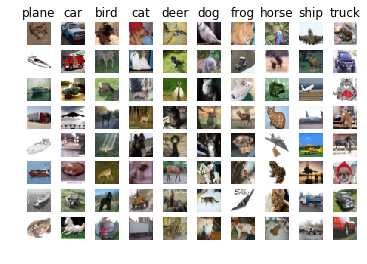

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?
I don't see low pixel image so clearly,but I also want to say taht above the algorithm doesn't work well.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
print(X_train_feats.shape)

(49000, 155)


In [23]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [19]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.089


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!